In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import corner
import scipy.stats as st
from statistics import mean, stdev
from collections import Counter
from math import floor,ceil

In [2]:
file_path = 'Datasets/mt_genes_metadata.csv'

met = pd.read_csv(file_path)

pro_code=met[met['gene_type']=='protein_coding']
intpro=pro_code['gene_name'].tolist()
intpro=['MT-ND1','MT-ND2','MT-ND3','MT-ND4','MT-ND4L','MT-ND5','MT-ND6', 'MT-CO1', 'MT-CO2','MT-CO3', 'MT-ATP6', 'MT-ATP8', 'MT-CYB']
intpro

['MT-ND1',
 'MT-ND2',
 'MT-ND3',
 'MT-ND4',
 'MT-ND4L',
 'MT-ND5',
 'MT-ND6',
 'MT-CO1',
 'MT-CO2',
 'MT-CO3',
 'MT-ATP6',
 'MT-ATP8',
 'MT-CYB']

In [3]:
file_path = 'Datasets/Donor1_CD4_Genes.csv'

p14 = pd.read_csv(file_path)

p14.drop(columns=p14.columns[0], axis=1, inplace=True)

p14_int=pd.DataFrame([p14[i] for i in intpro]).T

file_path = 'Datasets/Donor1_CD8_Genes.csv'

p18 = pd.read_csv(file_path)

p18.drop(columns=p18.columns[0], axis=1, inplace=True)

p18_int=pd.DataFrame([p18[i] for i in intpro]).T

file_path = 'Datasets/Donor2_CD4_Genes.csv'

p24 = pd.read_csv(file_path)

p24.drop(columns=p24.columns[0], axis=1, inplace=True)

p24_int=pd.DataFrame([p24[i] for i in intpro]).T

file_path = 'Datasets/Donor2_CD8_Genes.csv'

p28 = pd.read_csv(file_path)

p28.drop(columns=p28.columns[0], axis=1, inplace=True)

p28_int=pd.DataFrame([p28[i] for i in intpro]).T

total=pd.concat([p14,p18,p24,p28])

total_int=pd.concat([p14_int,p18_int, p24_int,p28_int])

totaln=len(total_int)


In [4]:
total_sampto=total.sum() #total number of each gene
totalgene=total_sampto.sum() #total number of genes


In [5]:
#number of DNA strands in each file
p14n=len(p14_int)
p18n=len(p18_int)
p24n=len(p24_int)
p28n=len(p28_int)

In [6]:
#Calculates the number of genes for each DNA
p14_allsampto=p14.sum(axis=1)
p18_allsampto=p18.sum(axis=1)
p24_allsampto=p24.sum(axis=1)
p28_allsampto=p28.sum(axis=1)

In [7]:
#Calculates the total number of interested genes for each DNA
p14_intsampto=p14_int.sum(axis=1)
p18_intsampto=p18_int.sum(axis=1)
p24_intsampto=p24_int.sum(axis=1)
p28_intsampto=p28_int.sum(axis=1)

Deepcopy of dataframes for normalisations

In [8]:
p14_intsampto

0       231
1       166
2       134
3       137
4        94
       ... 
2883     80
2884    113
2885    108
2886    237
2887    109
Length: 2888, dtype: int64

In [9]:
p14_n1=p14_int.copy(deep=True)
p18_n1=p18_int.copy(deep=True)
p24_n1=p24_int.copy(deep=True)
p28_n1=p28_int.copy(deep=True)

p14_n2=p14_int.copy(deep=True)
p18_n2=p18_int.copy(deep=True)
p24_n2=p24_int.copy(deep=True)
p28_n2=p28_int.copy(deep=True)



Normalising data by 100/(total interested genes - tested gene) 

In [10]:
r=100
for j in intpro:
    for i in range(p14n): 
        if p14_intsampto[i]==0:
            pass
        else:
            norm_cons=(p14_intsampto[i])/r #inidividual normalisation constant
            p14_n1.loc[i,j]=p14_int[j][i]/norm_cons

for j in intpro:
    for i in range(p18n): 
        if p18_intsampto[i]==0:
            pass
        else:
            norm_cons=(p18_intsampto[i])/r #inidividual normalisation constant
            p18_n1.loc[i,j]=p18_int[j][i]/norm_cons


for j in intpro:
    for i in range(p24n): 
        if p24_intsampto[i]==0:
            pass
        else:
            norm_cons=(p24_intsampto[i])/r #inidividual normalisation constant
            p24_n1.loc[i,j]=p24_int[j][i]/norm_cons


for j in intpro:
    for i in range(p28n): 
        if p28_intsampto[i]==0:
            pass
        else:
            norm_cons=(p28_intsampto[i])/r #inidividual normalisation constant
            p28_n1.loc[i,j]=p28_int[j][i]/norm_cons

C:\Users\lizar\AppData\Local\Temp\ipykernel_29444\3136499451.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.194805194805195' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n1.loc[i,j]=p14_int[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_29444\3136499451.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2987012987012987' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n1.loc[i,j]=p14_int[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_29444\3136499451.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.5974025974025974' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n1

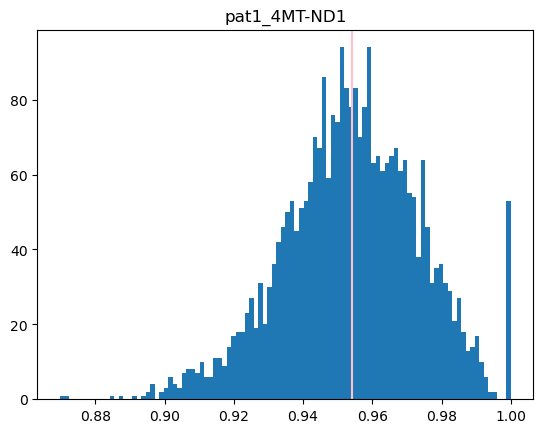

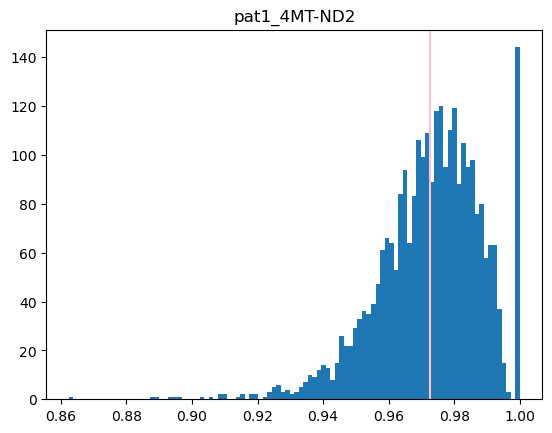

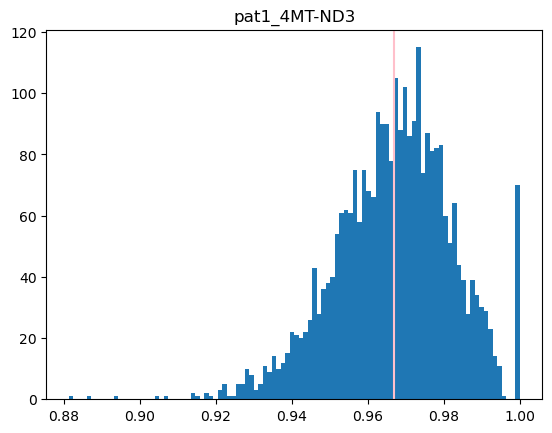

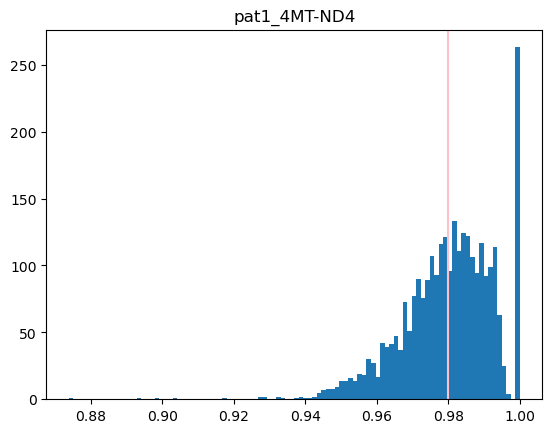

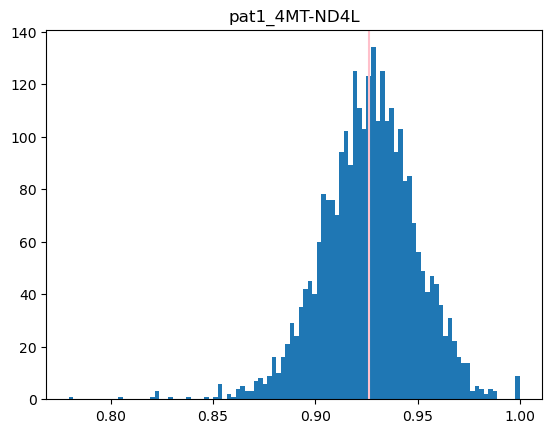

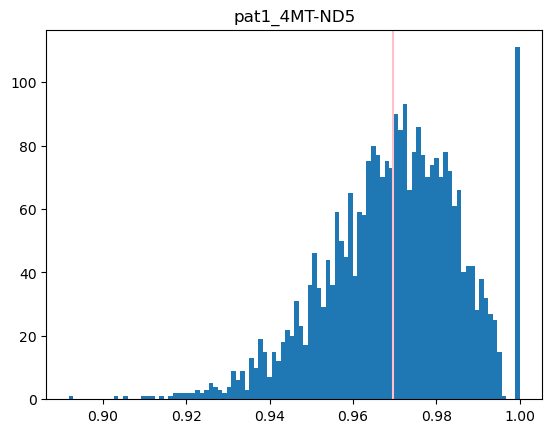

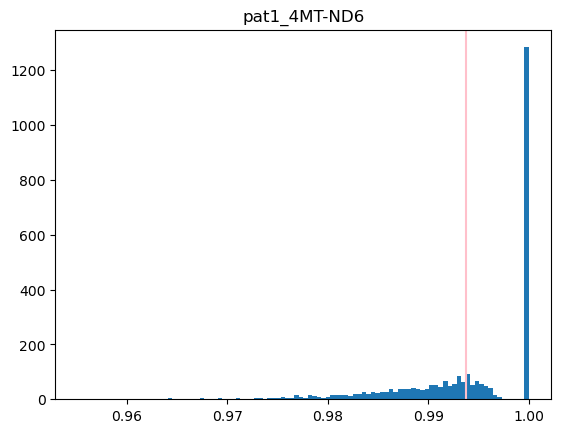

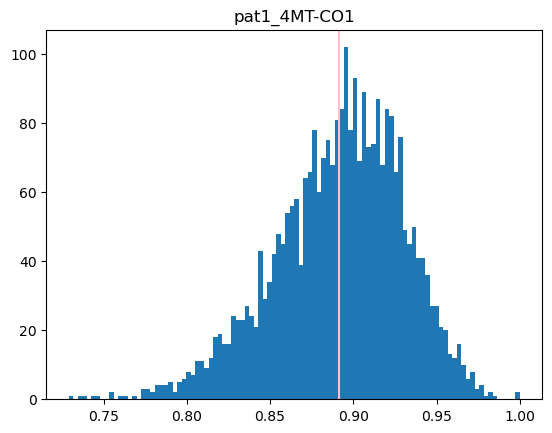

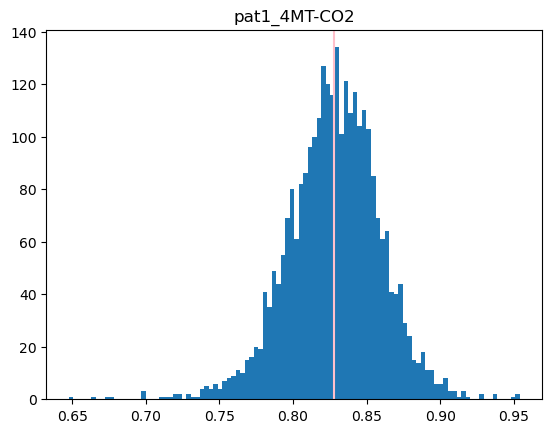

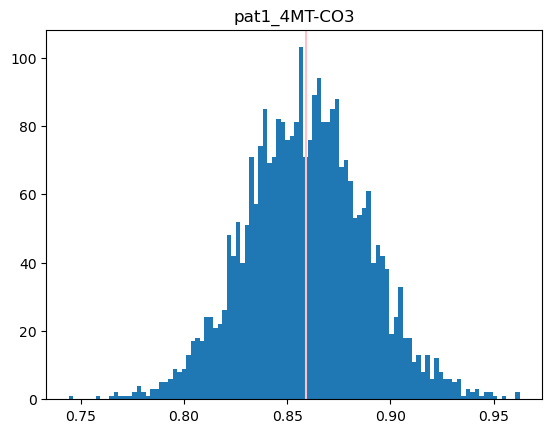

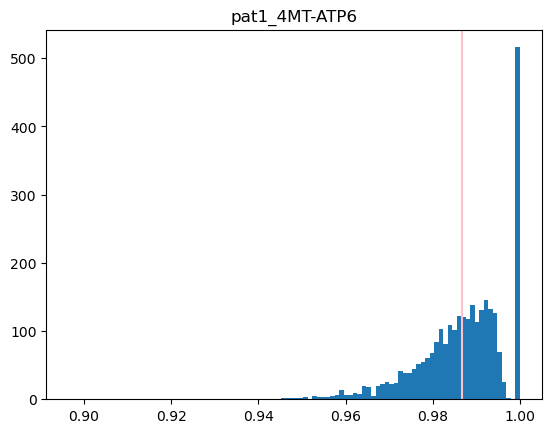

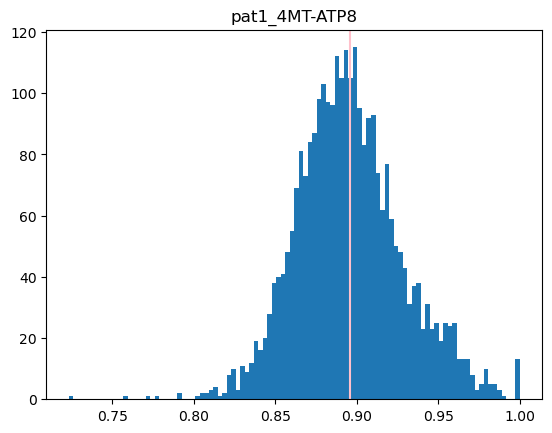

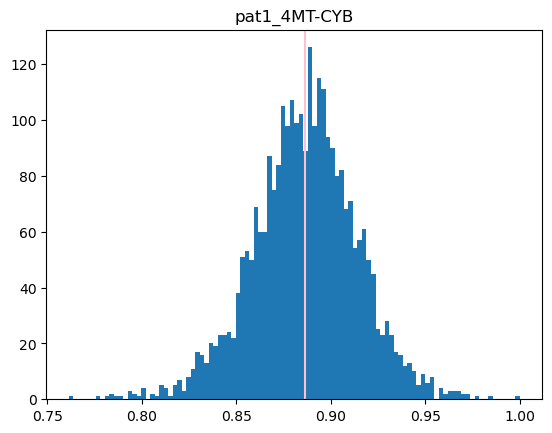

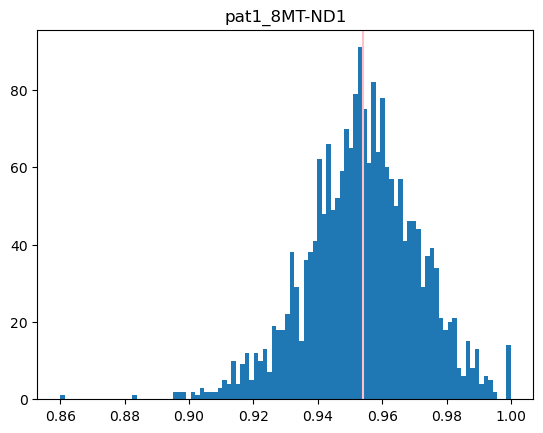

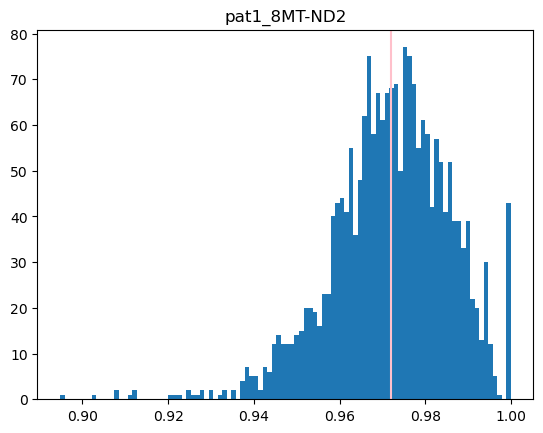

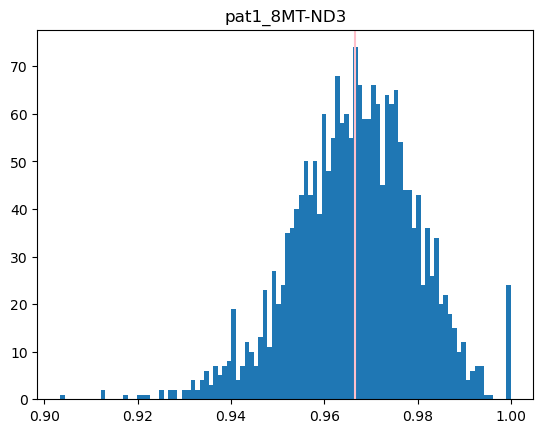

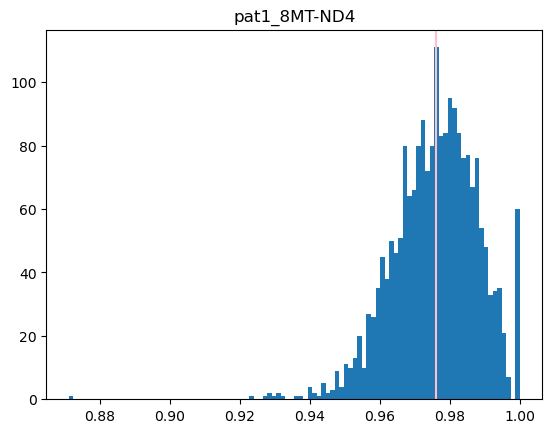

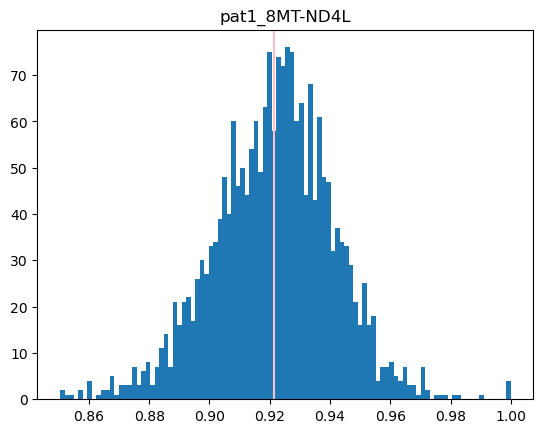

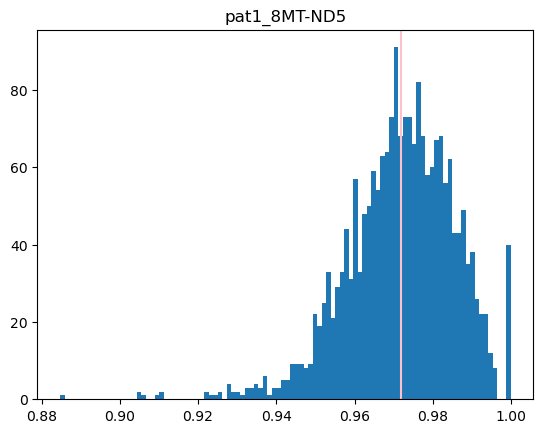

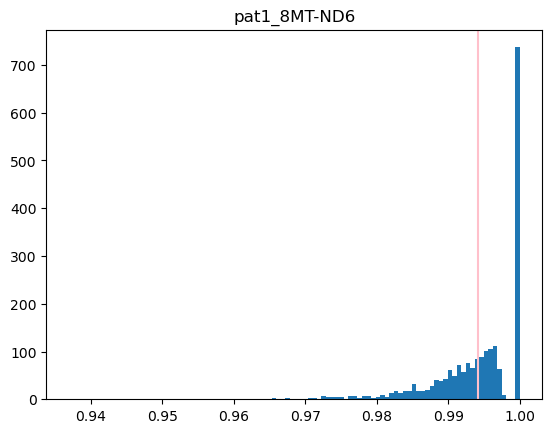

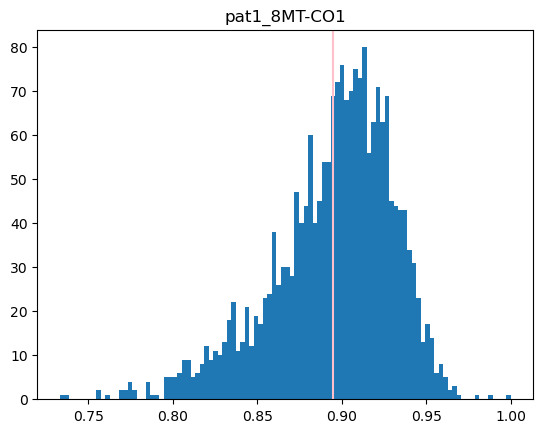

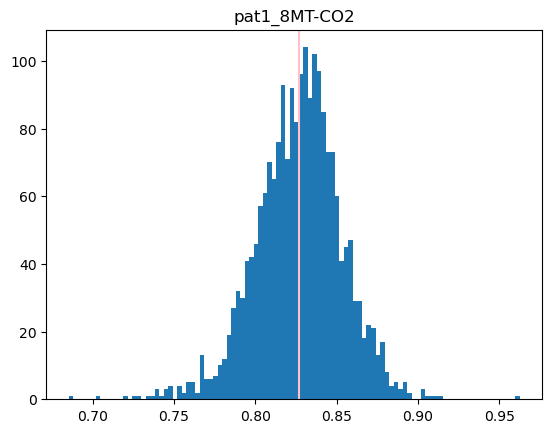

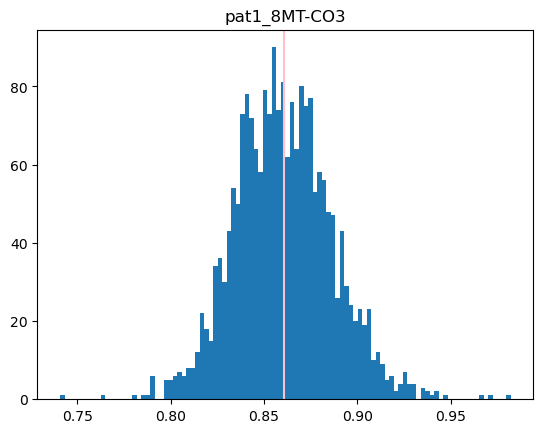

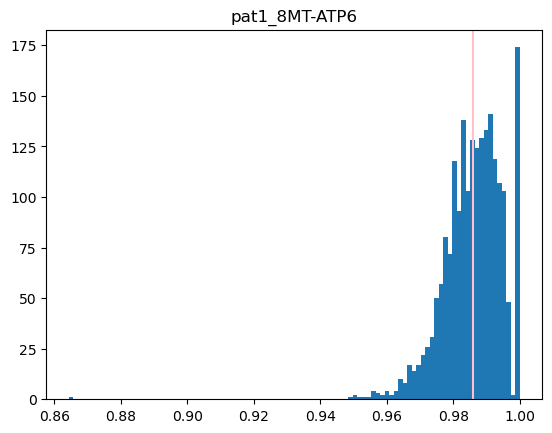

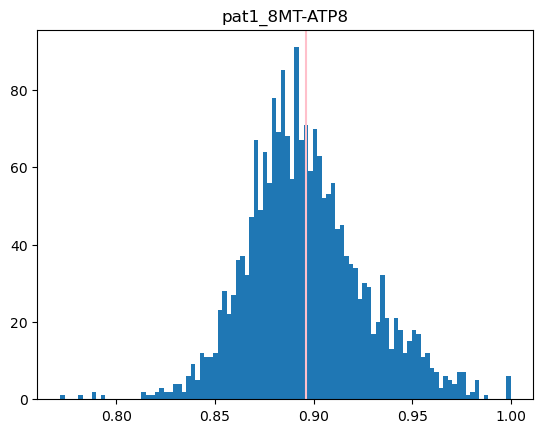

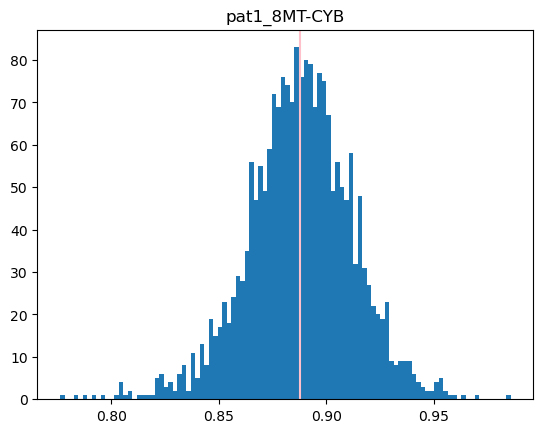

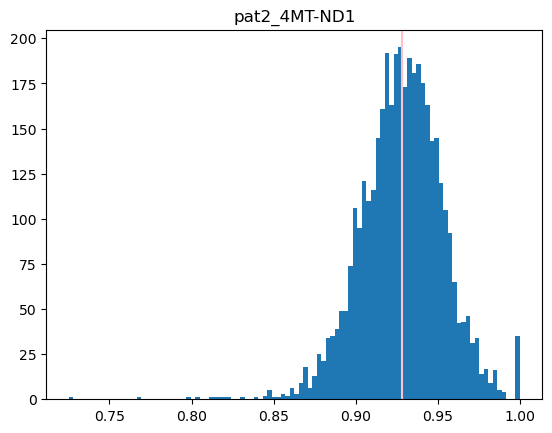

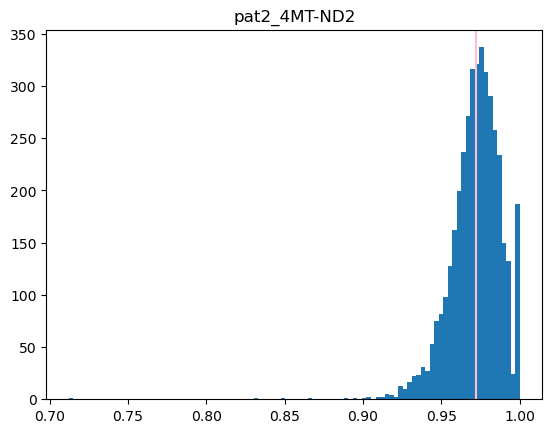

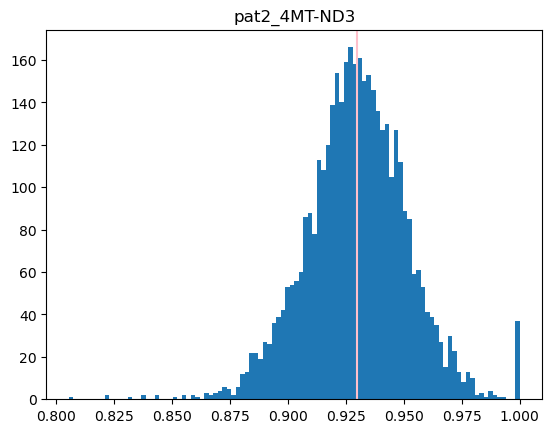

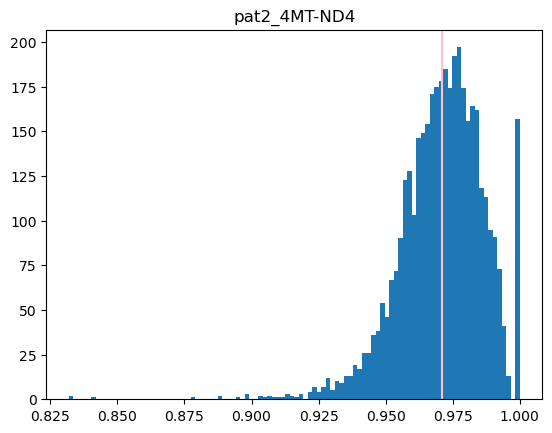

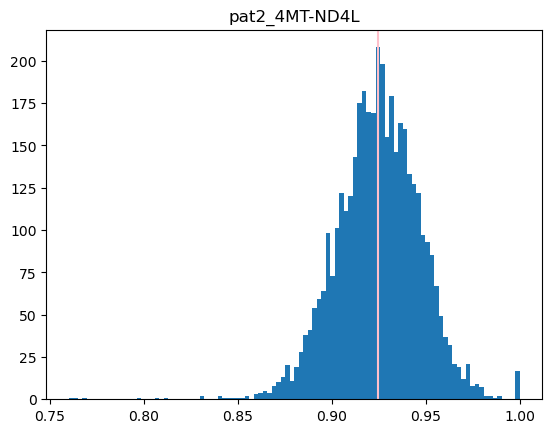

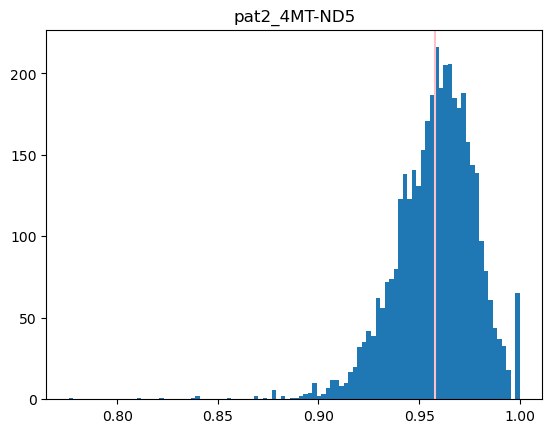

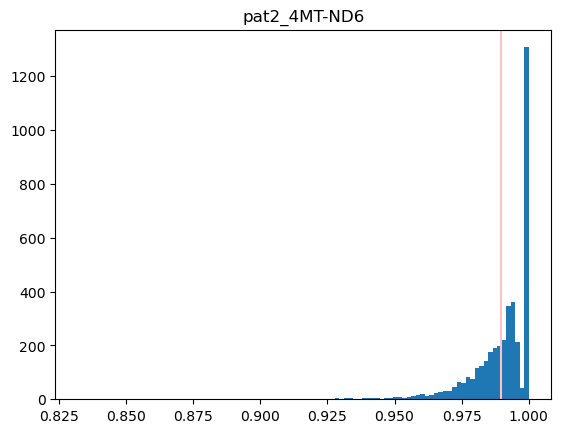

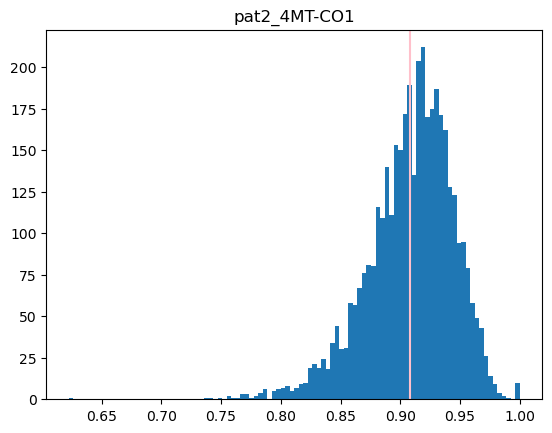

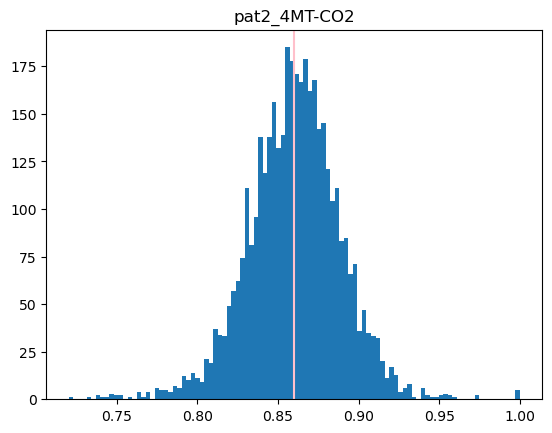

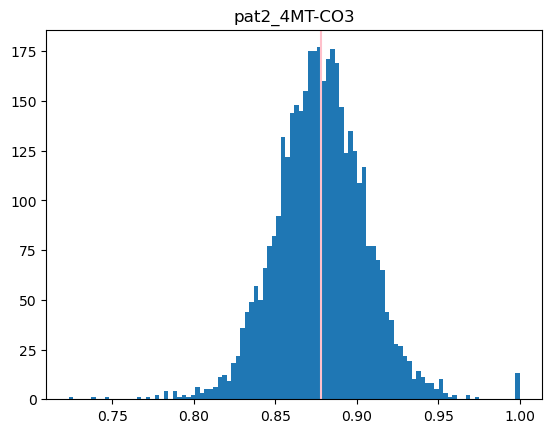

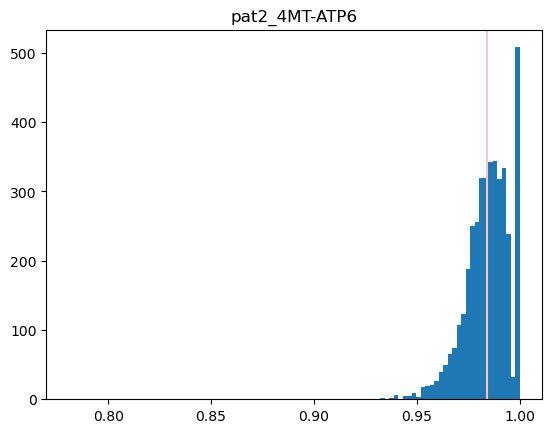

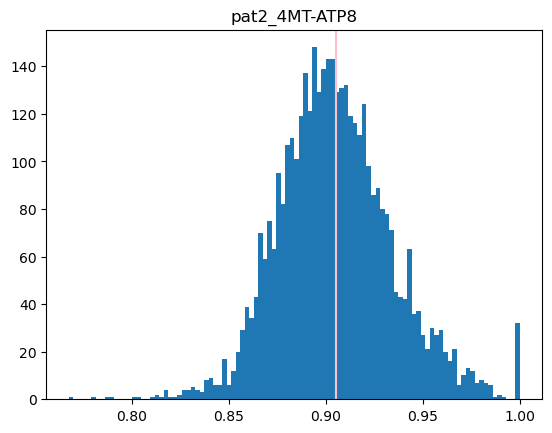

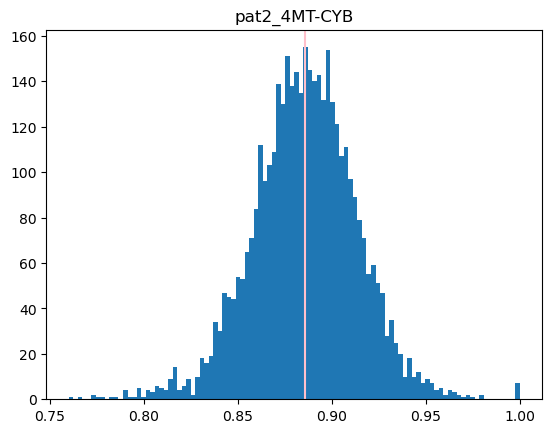

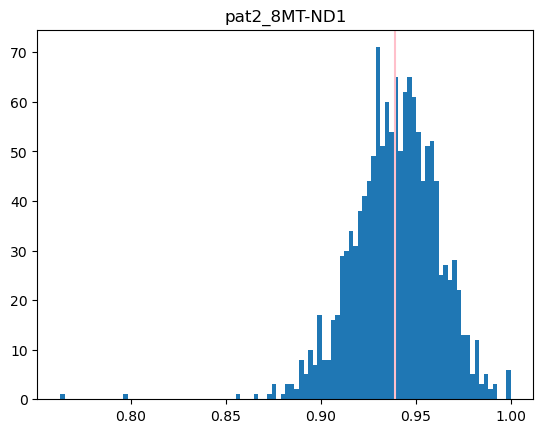

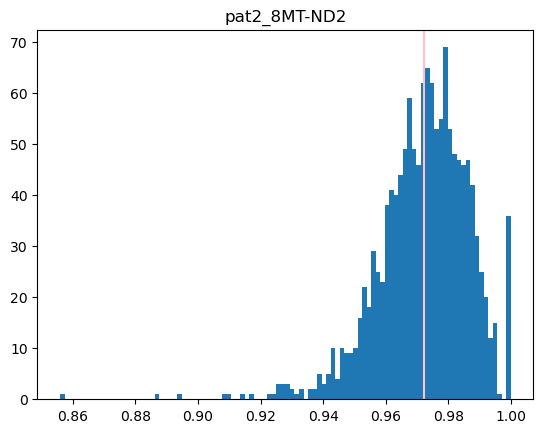

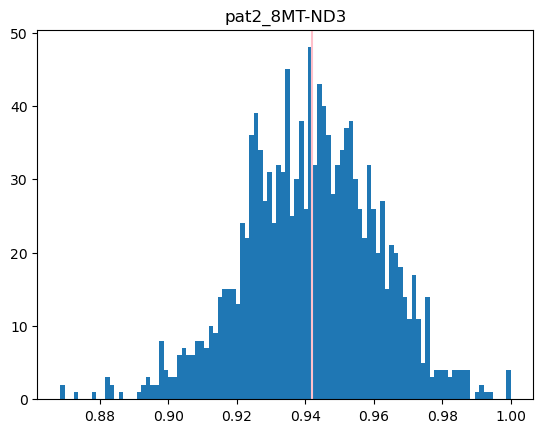

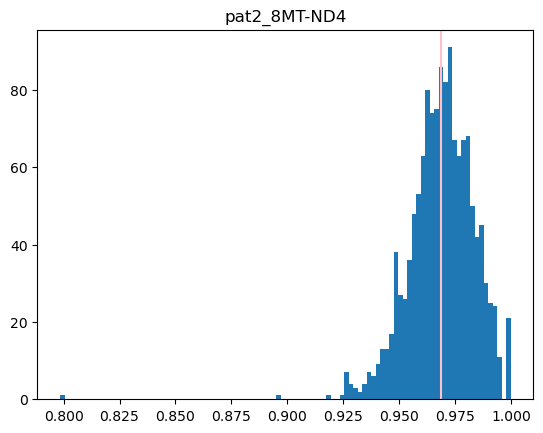

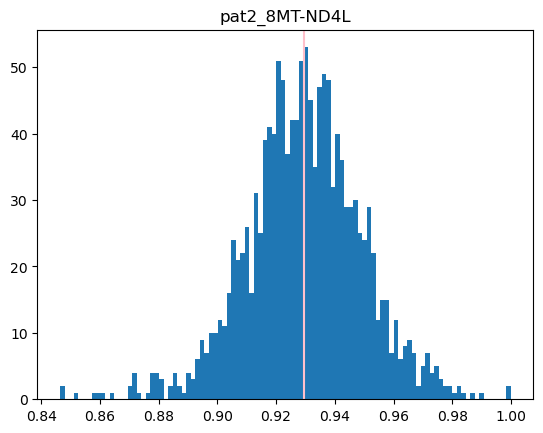

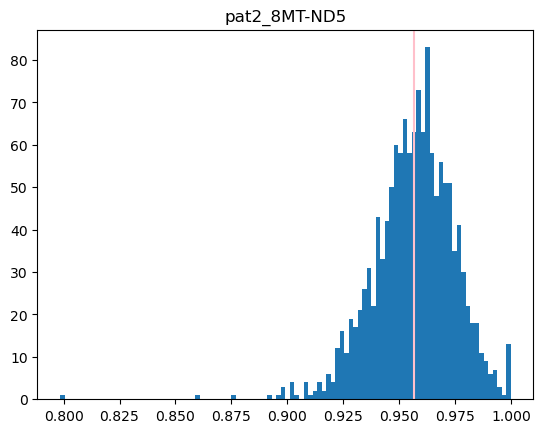

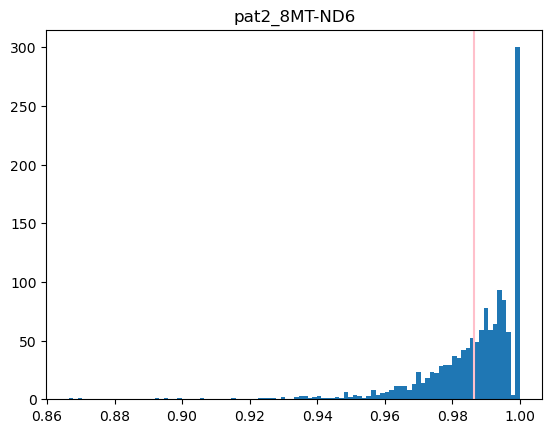

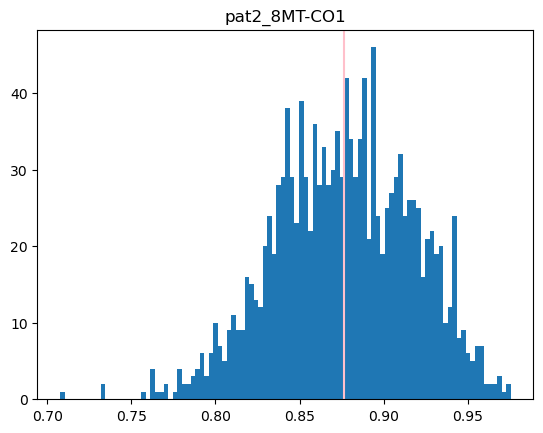

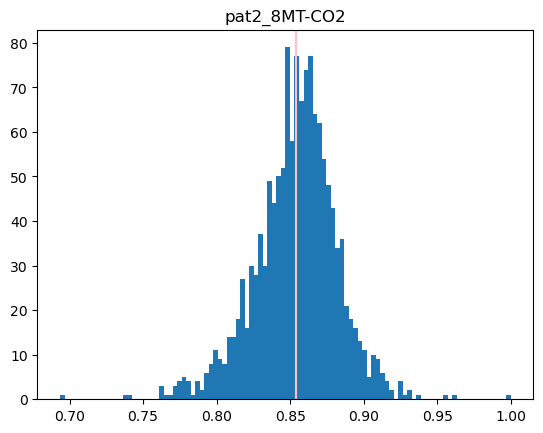

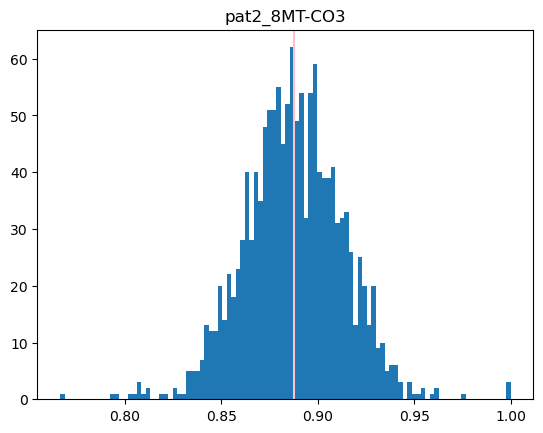

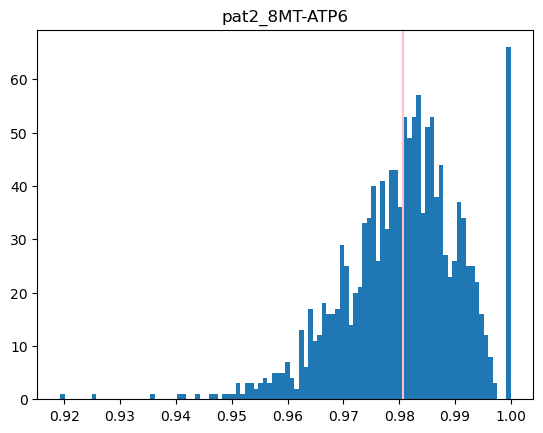

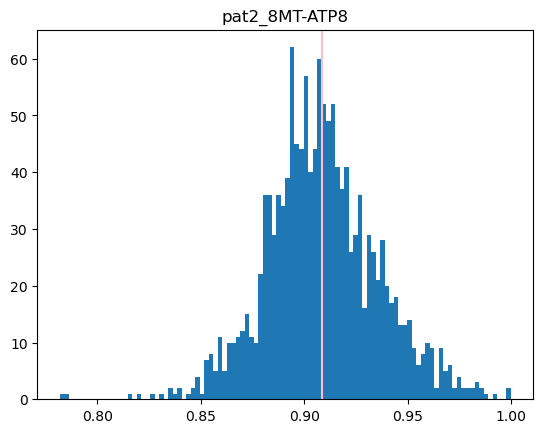

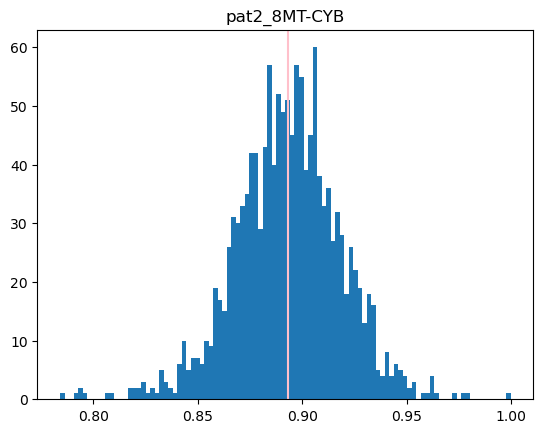

In [11]:
r=100
uem14int_list=[]
for j in intpro:
    uem14int_sample_list=[]
    for i in range(p14n): 
        if p14_intsampto[i]==0:
            pass
        else:
            x=p14_n1[j][i]
            uem=(r-1)/(x+r-1)
            uem14int_sample_list.append(uem)
    uem14int_list.append(mean(uem14int_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem14int_sample_list,bins=100)
    ax.axvline(mean(uem14int_sample_list), color='pink')
    plt.show()
uem14int_list=dict(zip(intpro,uem14int_list))
df14int=len(uem14int_sample_list)-1

uem18int_list=[]
for j in intpro:
    uem18int_sample_list=[]
    for i in range(p18n): 
        if p18_intsampto[i]==0:
            pass
        else:
            x=p18_n1[j][i]
            uem=(r-1)/(x+r-1)
            uem18int_sample_list.append(uem)
    uem18int_list.append(mean(uem18int_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_8'+''+j)
    ax.hist(uem18int_sample_list,bins=100)
    ax.axvline(mean(uem18int_sample_list), color='pink')
    plt.show()
uem18int_list=dict(zip(intpro,uem18int_list))
df18int=len(uem18int_sample_list)-1

uem24int_list=[]
for j in intpro:
    uem24int_sample_list=[]
    for i in range(p24n): 
        if p24_intsampto[i]==0:
            pass
        else:
            x=p24_n1[j][i]
            uem=(r-1)/(x+r-1)
            uem24int_sample_list.append(uem)
    uem24int_list.append(mean(uem24int_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat2_4'+''+j)
    ax.hist(uem24int_sample_list,bins=100)
    ax.axvline(mean(uem24int_sample_list), color='pink')
    plt.show()
uem24int_list=dict(zip(intpro,uem24int_list))
df24int=len(uem24int_sample_list)-1

uem28int_list=[]
for j in intpro:
    uem28int_sample_list=[]
    for i in range(p28n): 
        if p28_intsampto[i]==0:
            pass
        else:
            norm_cons=(p28_intsampto[i]-p28_int[j][i])/r #inidividual normalisation constant
            x=p28_n1[j][i]
            uem=(r-1)/(x+r-1)
            uem28int_sample_list.append(uem)
    uem28int_list.append(mean(uem28int_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat2_8'+''+j)
    ax.hist(uem28int_sample_list,bins=100)
    ax.axvline(mean(uem28int_sample_list), color='pink')
    plt.show()
uem28int_list=dict(zip(intpro,uem28int_list))
df28int=len(uem28int_sample_list)-1

χ² test: H0: Follows nbin, H1: Doesn't Follow

In [12]:
#p1_4_int
cv=st.chi2.ppf(0.99,df14int)
chi1_p14int_ts=[]
chi1_p14int_res=[]
for j in intpro:
    ts=0
    p=uem14int_list[j]
    for i in range(p14n):
        if p14_intsampto[i]==0:
            pass
        else:
            r=100
            o=p14_n1[j][i]
            e=r*(1-p)/p
            ts+=(e-o)**2/e
    chi1_p14int_ts.append(ts)
    chi1_p14int_res.append(ts-cv)
chi1_p14int_res=dict(zip(intpro,chi1_p14int_res))
chi1_p14int_res

{'MT-ND1': -291.64113529149154,
 'MT-ND2': -133.86257669500128,
 'MT-ND3': -803.214688712681,
 'MT-ND4': -423.7678540957786,
 'MT-ND4L': -426.75557268396096,
 'MT-ND5': -403.2234720477709,
 'MT-ND6': -424.45782583908203,
 'MT-CO1': 2773.2839111332496,
 'MT-CO2': -67.64301563654408,
 'MT-CO3': -339.26018043226895,
 'MT-ATP6': -478.5253961751405,
 'MT-ATP8': 949.4060005148435,
 'MT-CYB': -262.0137086207842}

In [13]:
#p1_8_int
cv=st.chi2.ppf(0.99,df18int)
chi1_p18int_ts=[]
chi1_p18int_res=[]
for j in intpro:
    ts=0
    p=uem18int_list[j]
    for i in range(p18n):
        if p18_intsampto[i]==0:
            pass
        else:
            r=100
            o=p18_n1[j][i]
            e=r*(1-p)/p
            ts+=(e-o)**2/e
    chi1_p18int_ts.append(ts)
    chi1_p18int_res.append(ts-cv)
chi1_p18int_res=dict(zip(intpro,chi1_p18int_res))
chi1_p18int_res

{'MT-ND1': -676.5936655157097,
 'MT-ND2': -699.2724818494362,
 'MT-ND3': -1070.3426868876538,
 'MT-ND4': -874.5696546126185,
 'MT-ND4L': -915.2533234797331,
 'MT-ND5': -683.3686437630904,
 'MT-ND6': -642.6609604837972,
 'MT-CO1': 1605.58555956784,
 'MT-CO2': -735.4168578622662,
 'MT-CO3': -693.5046625062839,
 'MT-ATP6': -960.3705367219816,
 'MT-ATP8': 207.71223413960024,
 'MT-CYB': -627.5509564179731}

In [14]:
#p2_4_int
cv=st.chi2.ppf(0.99,df24int)
chi1_p24int_ts=[]
chi1_p24int_res=[]
for j in intpro:
    ts=0
    p=uem24int_list[j]
    for i in range(p24n):
        if p24_intsampto[i]==0:
            pass
        else:
            r=100
            o=p24_n1[j][i]
            e=r*(1-p)/p
            ts+=(e-o)**2/e
    chi1_p24int_ts.append(ts)
    chi1_p24int_res.append(ts-cv)
chi1_p24int_res=dict(zip(intpro,chi1_p24int_res))
chi1_p24int_res

{'MT-ND1': 173.43492402542051,
 'MT-ND2': 178.75715907864924,
 'MT-ND3': -861.668013385508,
 'MT-ND4': -328.20507323956144,
 'MT-ND4L': -780.812785385086,
 'MT-ND5': 264.11872598691025,
 'MT-ND6': 2792.960994490959,
 'MT-CO1': 3973.0161186059922,
 'MT-CO2': -470.2852747144175,
 'MT-CO3': -564.1440521120958,
 'MT-ATP6': -358.94790877462765,
 'MT-ATP8': 585.4109631830315,
 'MT-CYB': -313.6610153042261}

In [15]:
#p2_8_int
cv=st.chi2.ppf(0.99,df28int)
chi1_p28int_ts=[]
chi1_p28int_res=[]
for j in intpro:
    ts=0
    p=uem28int_list[j]
    for i in range(p28n):
        if p28_intsampto[i]==0:
            pass
        else:
            r=100
            o=p28_n1[j][i]
            e=r*(1-p)/p
            ts+=(e-o)**2/e
    chi1_p28int_ts.append(ts)
    chi1_p28int_res.append(ts-cv)
chi1_p28int_res=dict(zip(intpro,chi1_p28int_res))
chi1_p28int_res

{'MT-ND1': -114.67619910717576,
 'MT-ND2': -327.6939125027136,
 'MT-ND3': -408.8546247329416,
 'MT-ND4': -402.9917541210302,
 'MT-ND4L': -550.0459096616985,
 'MT-ND5': -278.22558963513916,
 'MT-ND6': 997.3164952286904,
 'MT-CO1': 1354.0951982650265,
 'MT-CO2': -282.81250769815733,
 'MT-CO3': -377.4723113582929,
 'MT-ATP6': -662.4431078811932,
 'MT-ATP8': -44.893290008669055,
 'MT-CYB': -329.1247330456479}

In [16]:
chi1_p14_resdf=pd.Series(chi1_p14int_res)
chi1_p14_resdf=pd.DataFrame(chi1_p14_resdf,columns=['P1_4'])
chi1_p18_resdf=pd.Series(chi1_p18int_res)
chi1_p18_resdf=pd.DataFrame(chi1_p18_resdf,columns=['P1_8'])
chi1_p24_resdf=pd.Series(chi1_p24int_res)
chi1_p24_resdf=pd.DataFrame(chi1_p24_resdf,columns=['P2_4'])
chi1_p28_resdf=pd.Series(chi1_p28int_res)
chi1_p28_resdf=pd.DataFrame(chi1_p28_resdf,columns=['P2_8'])
overall_chi1_res=pd.concat([chi1_p14_resdf,chi1_p18_resdf,chi1_p24_resdf, chi1_p28_resdf], axis=1)
overall_chi1_res

,P1_4,P1_8,P2_4,P2_8
MT-ND1,-291.641135,-676.593666,173.434924,-114.676199
MT-ND2,-133.862577,-699.272482,178.757159,-327.693913
MT-ND3,-803.214689,-1070.342687,-861.668013,-408.854625
MT-ND4,-423.767854,-874.569655,-328.205073,-402.991754
MT-ND4L,-426.755573,-915.253323,-780.812785,-550.045910
MT-ND5,-403.223472,-683.368644,264.118726,-278.225590
MT-ND6,-424.457826,-642.660960,2792.960994,997.316495
MT-CO1,2773.283911,1605.585560,3973.016119,1354.095198
MT-CO2,-67.643016,-735.416858,-470.285275,-282.812508
MT-CO3,-339.260180,-693.504663,-564.144052,-377.472311


Normalising data: Normalising data by 1000/(total genes - tested gene) 

and then computing Unbiased estimate of neg binom proportion

Plotting the histograms of the UEM to estimate a prior for the UEM for posterior checks.

In [17]:
r=1000
for j in intpro:
    for i in range(p14n): 
        if p14_allsampto[i]==0:
            pass
        else:
            norm_cons=(p14_allsampto[i]-p14_int[j][i])/r #inidividual normalisation constant
            p14_n2.loc[i,j]=p14_int[j][i]/norm_cons


for j in intpro:
    for i in range(p18n): 
        if p18_allsampto[i]==0:
            pass
        else:
            norm_cons=(p18_allsampto[i]-p18_int[j][i])/r #inidividual normalisation constant
            p18_n2.loc[i,j]=p18_int[j][i]/norm_cons


for j in intpro:
    for i in range(p24n): 
        if p24_allsampto[i]==0:
            pass
        else:
            norm_cons=(p24_allsampto[i]-p24_int[j][i])/r #inidividual normalisation constant
            p24_n2.loc[i,j]=p24_int[j][i]/norm_cons


for j in intpro:
    for i in range(p28n): 
        if p28_allsampto[i]==0:
            pass
        else:
            norm_cons=(p28_allsampto[i]-p28_int[j][i])/r #inidividual normalisation constant
            p28_n2.loc[i,j]=p28_int[j][i]/norm_cons

C:\Users\lizar\AppData\Local\Temp\ipykernel_29444\215575072.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.817589576547232' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n2.loc[i,j]=p14_int[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_29444\215575072.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9430051813471503' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n2.loc[i,j]=p14_int[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_29444\215575072.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.893575600259572' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n2.loc

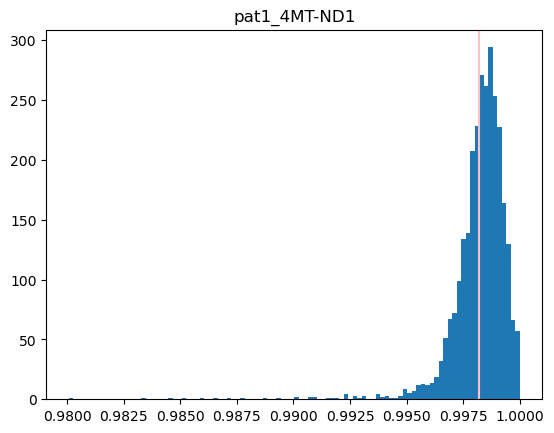

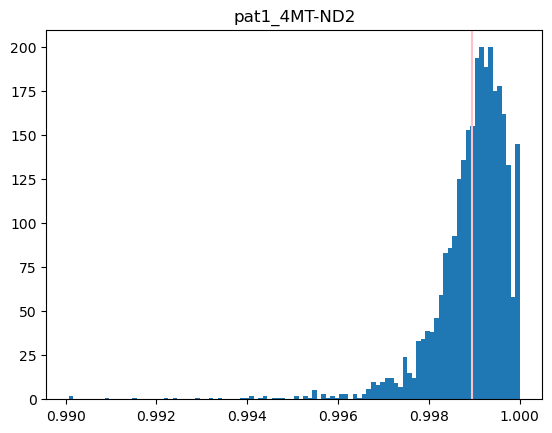

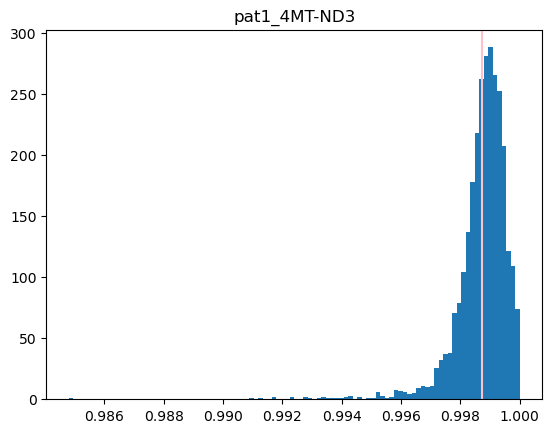

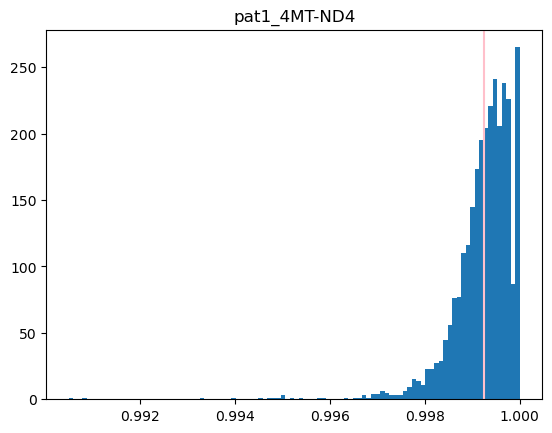

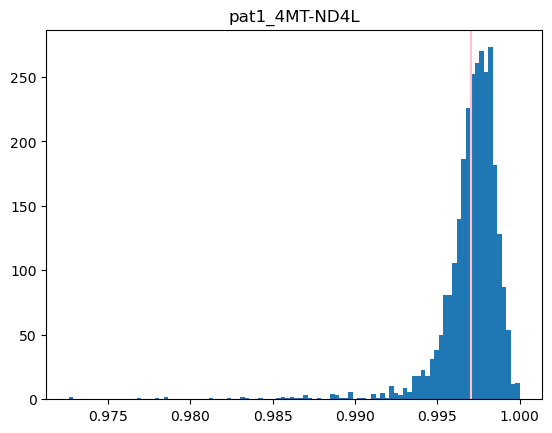

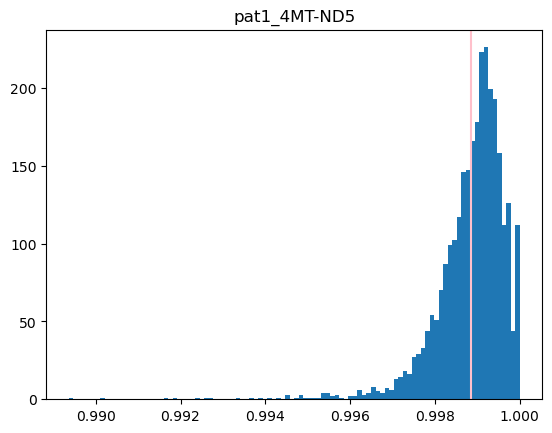

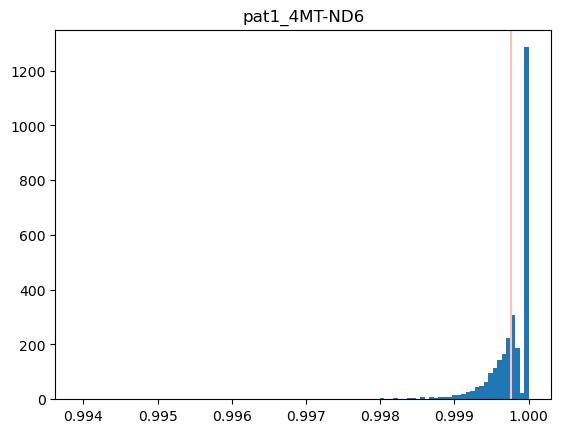

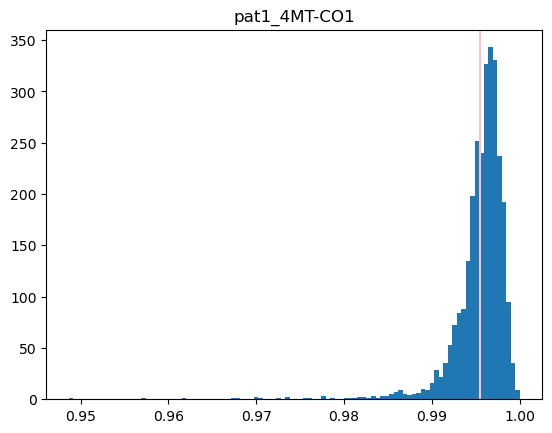

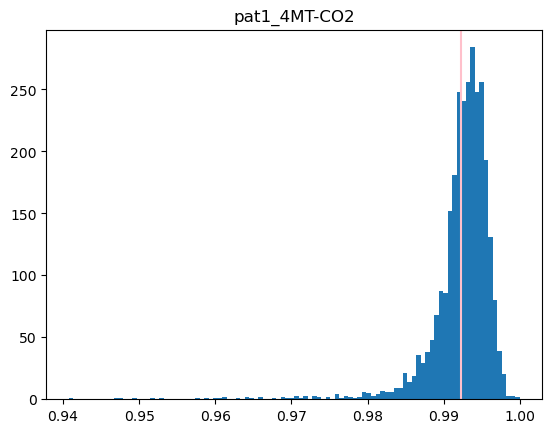

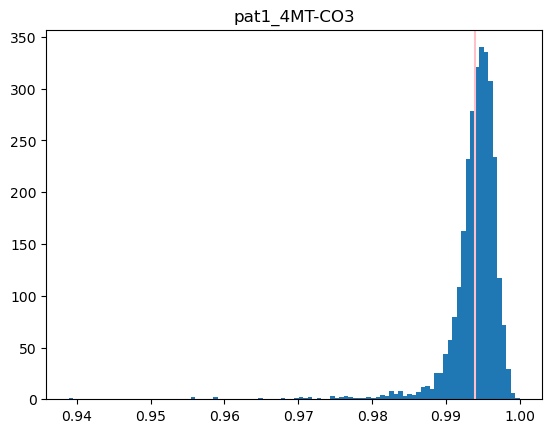

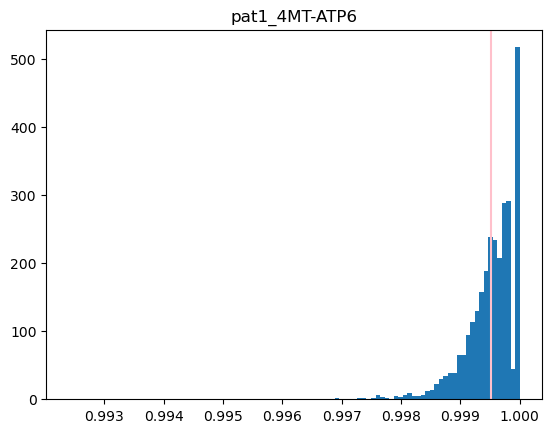

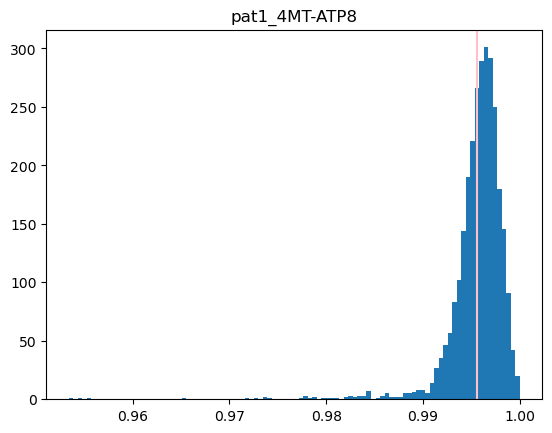

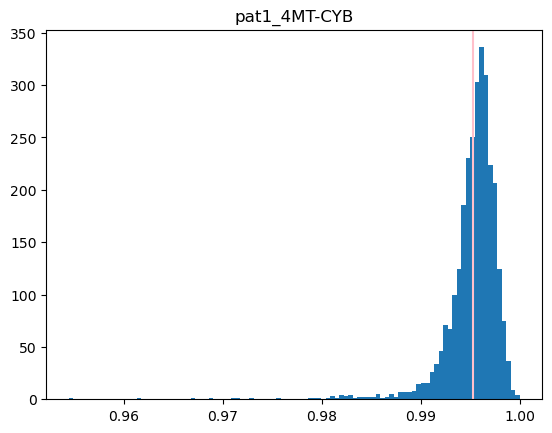

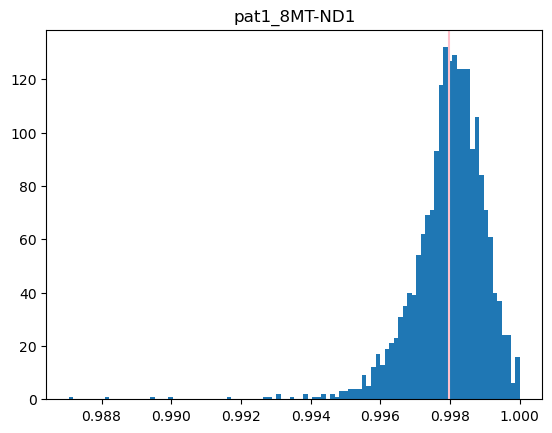

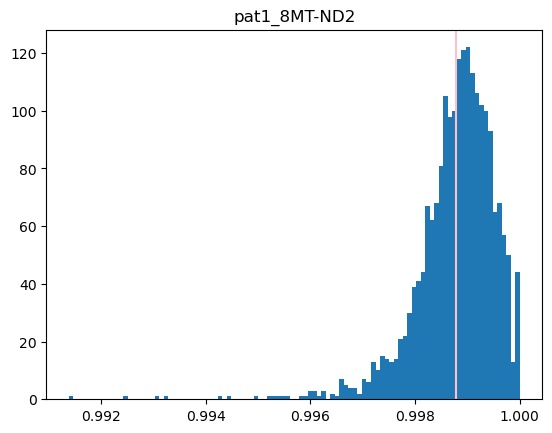

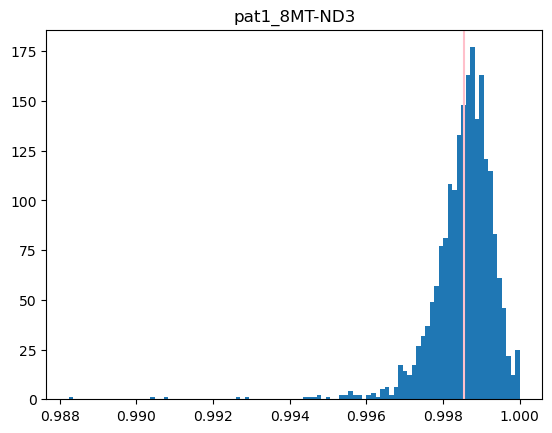

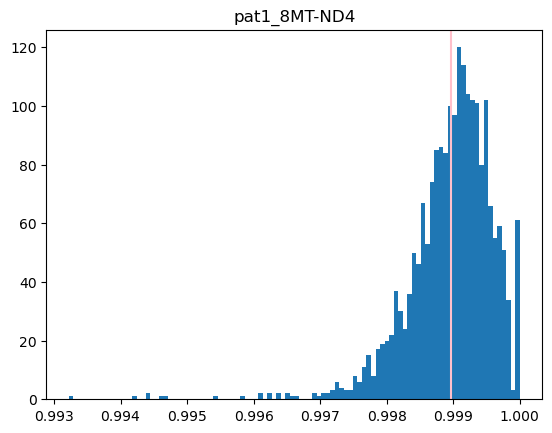

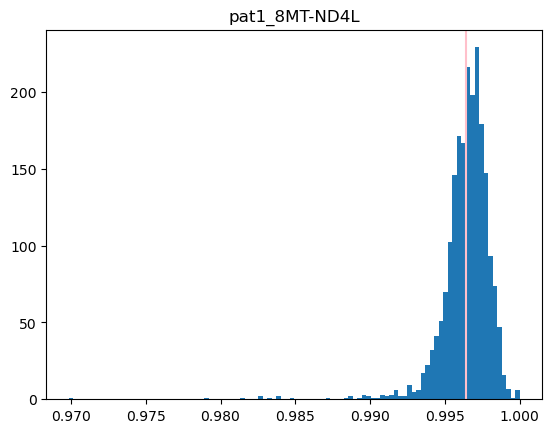

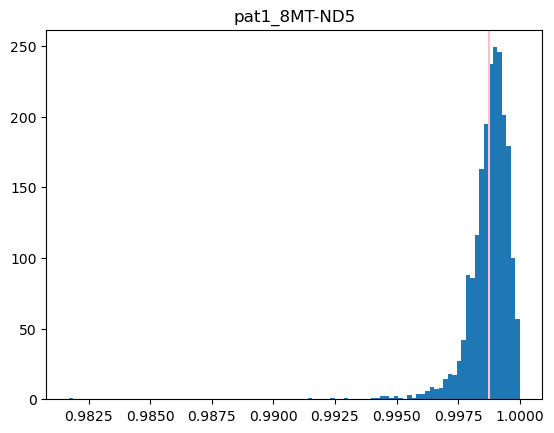

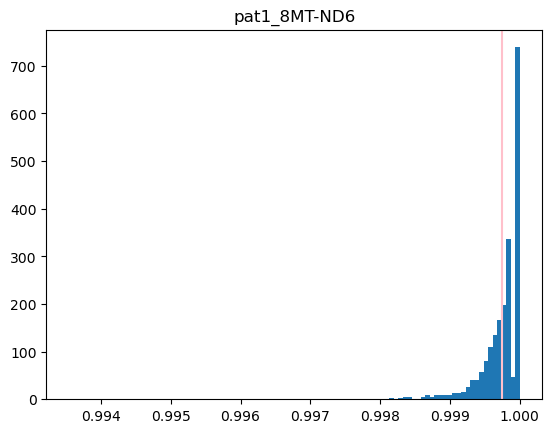

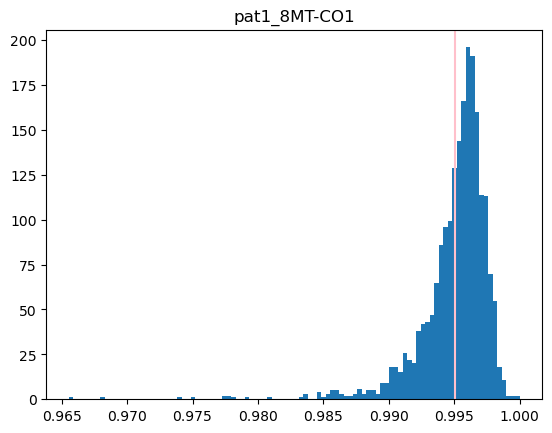

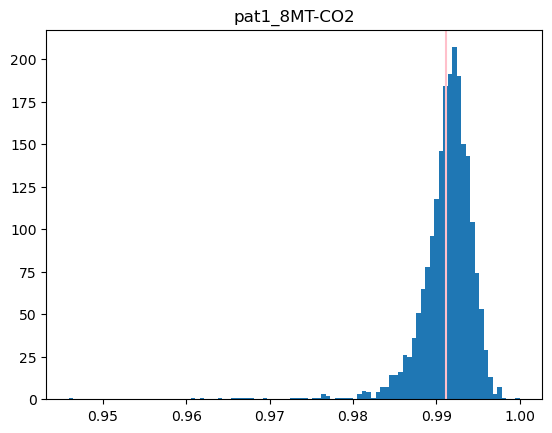

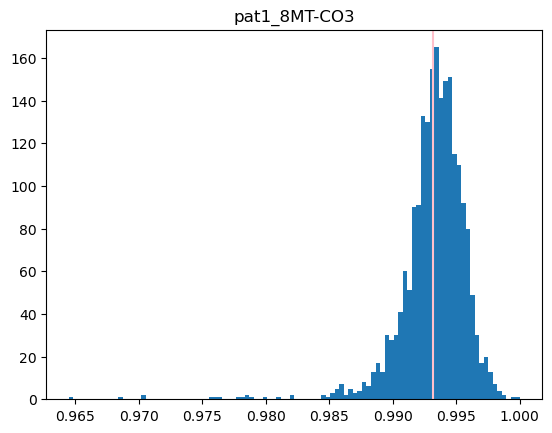

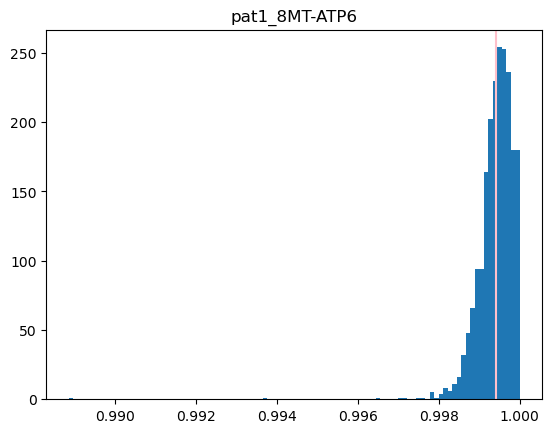

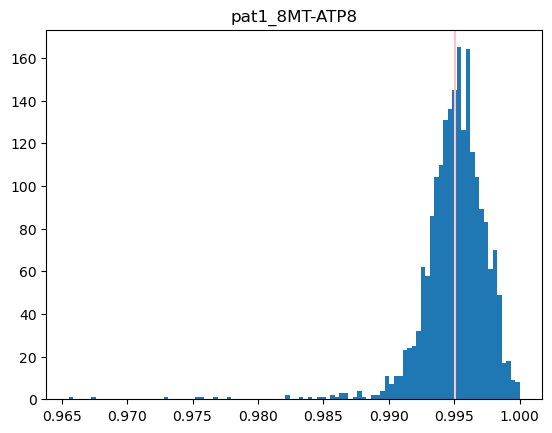

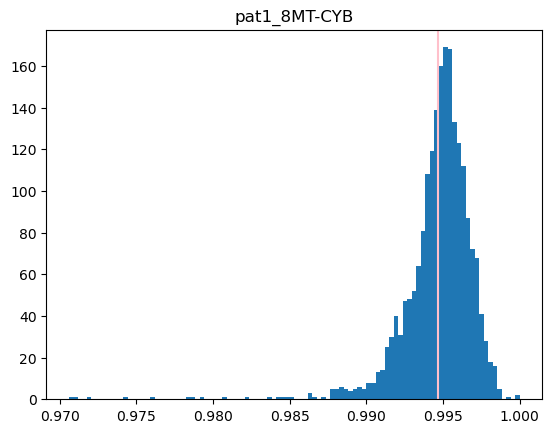

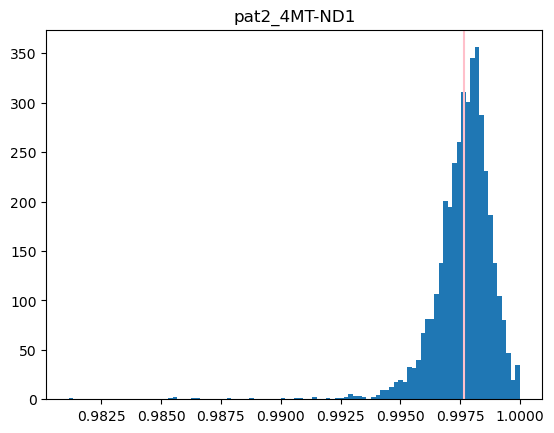

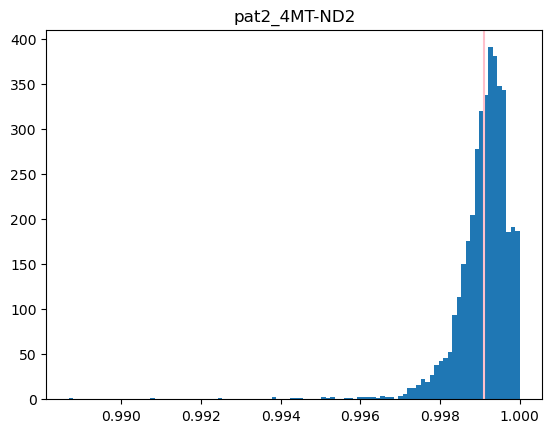

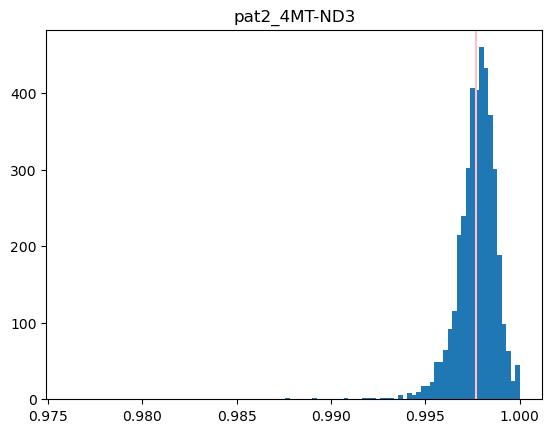

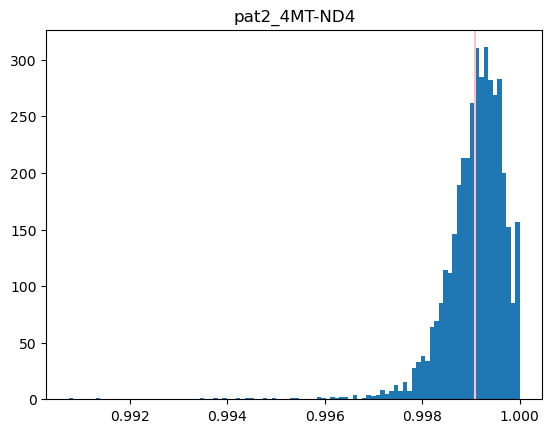

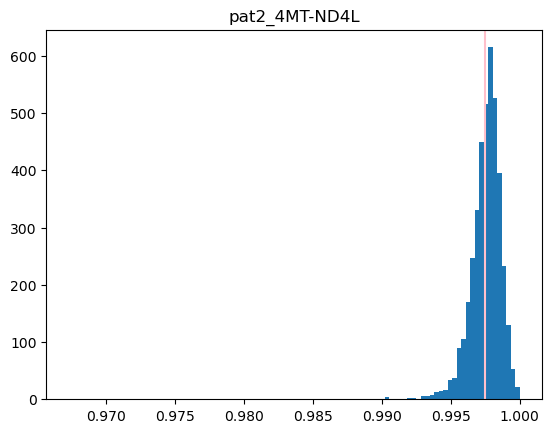

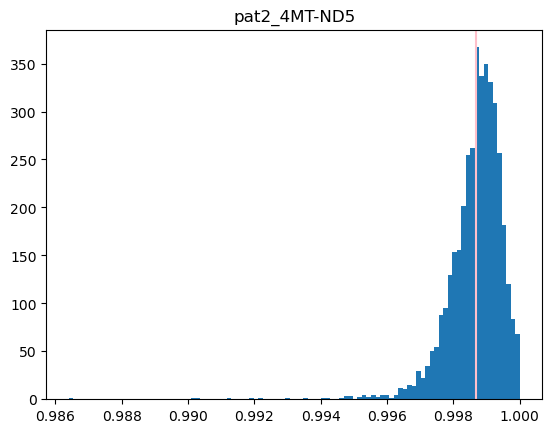

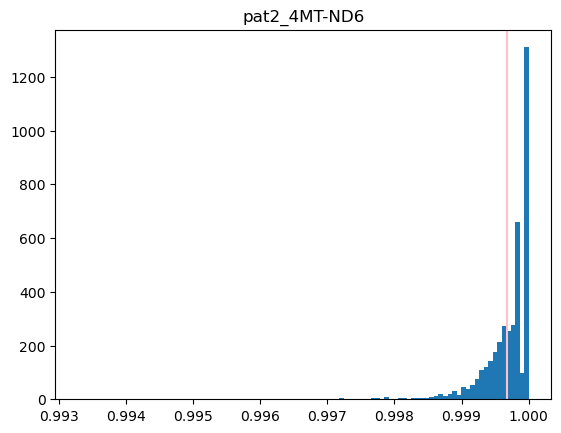

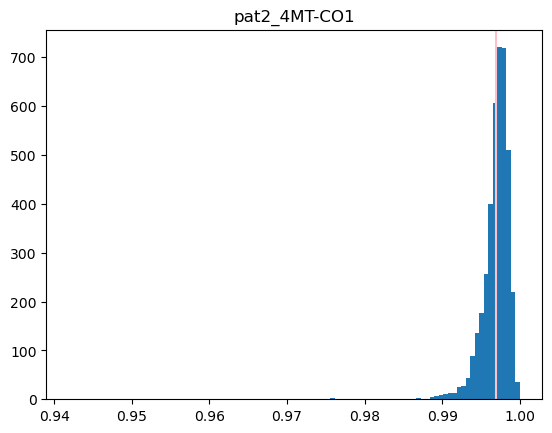

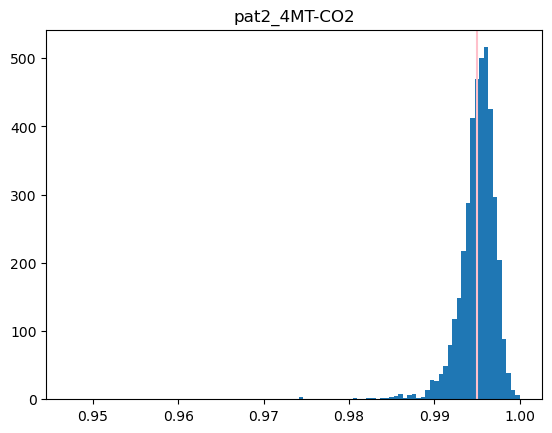

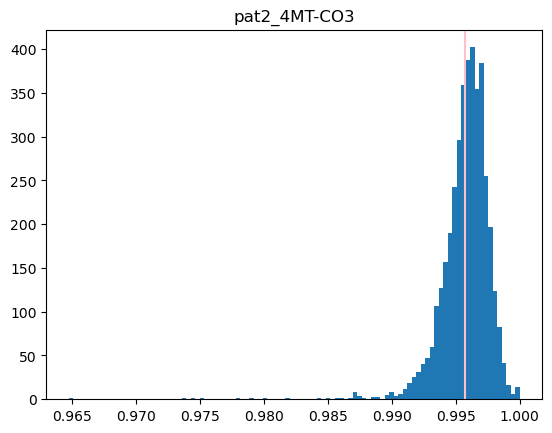

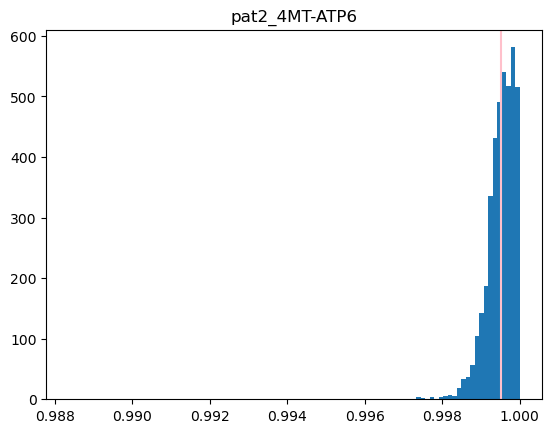

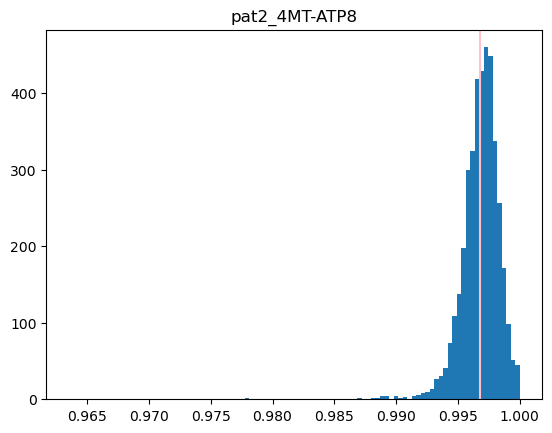

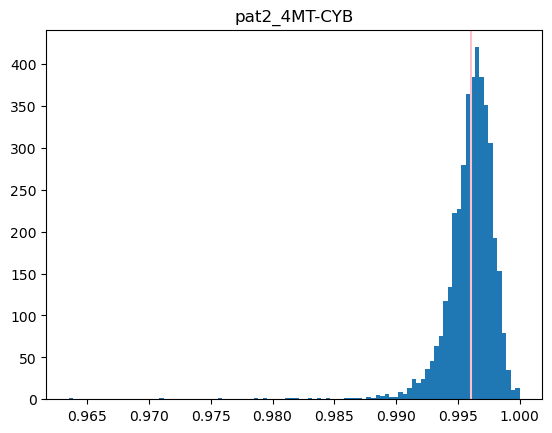

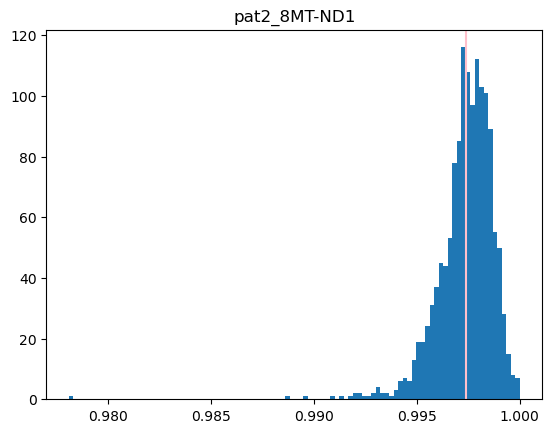

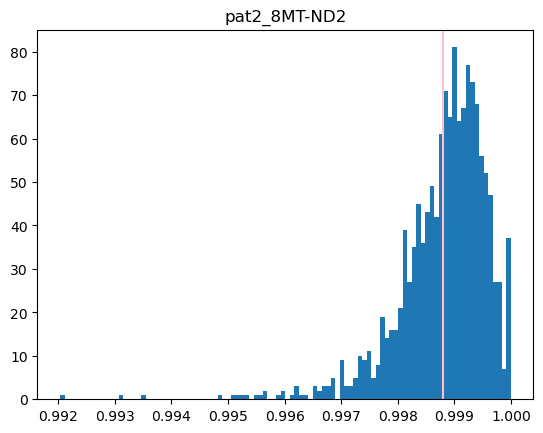

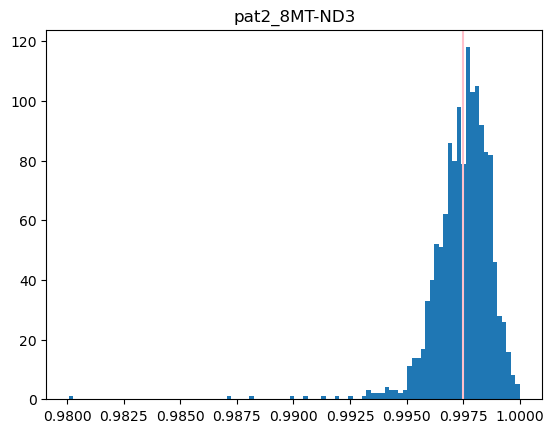

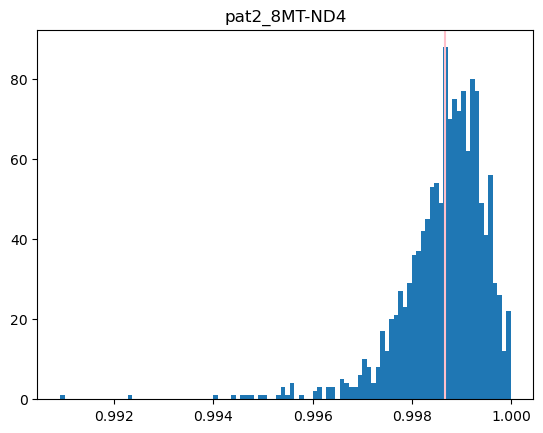

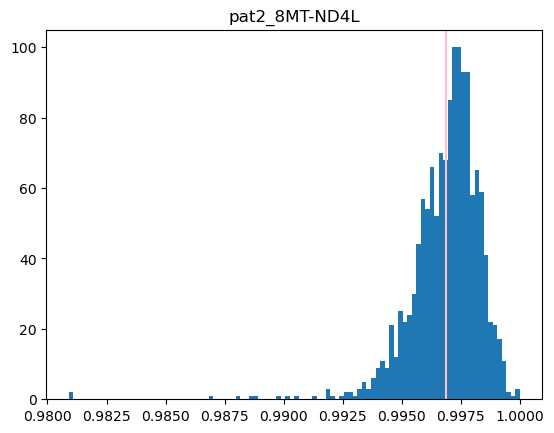

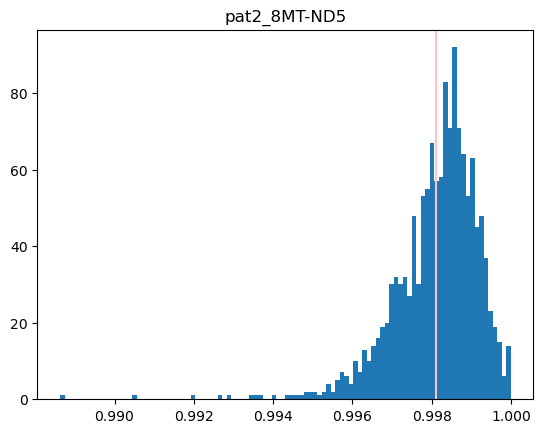

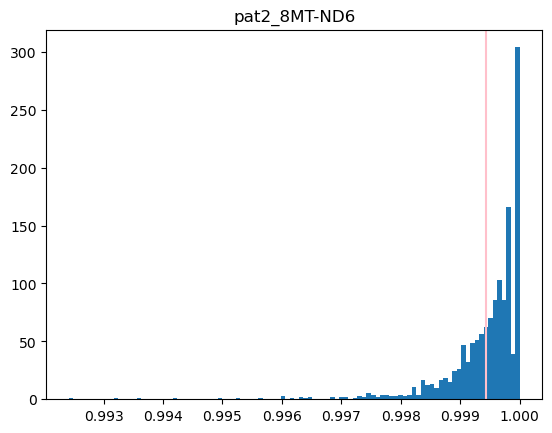

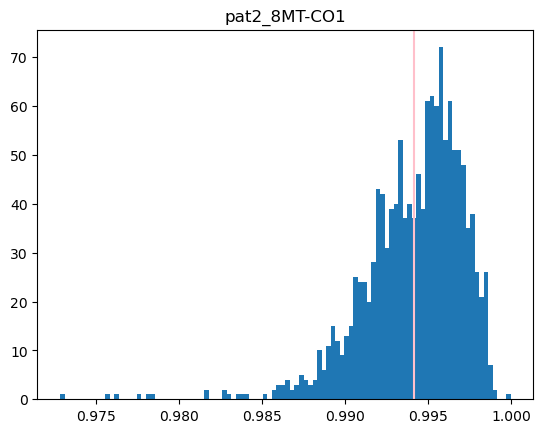

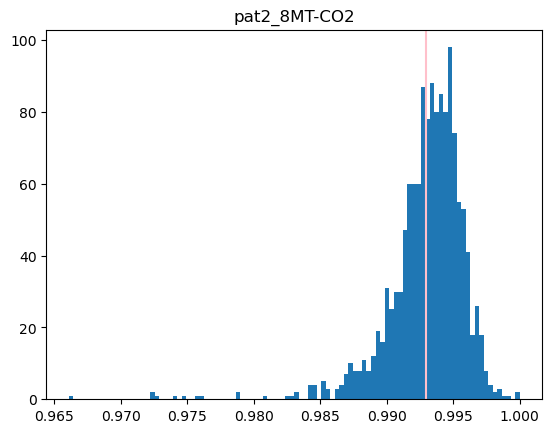

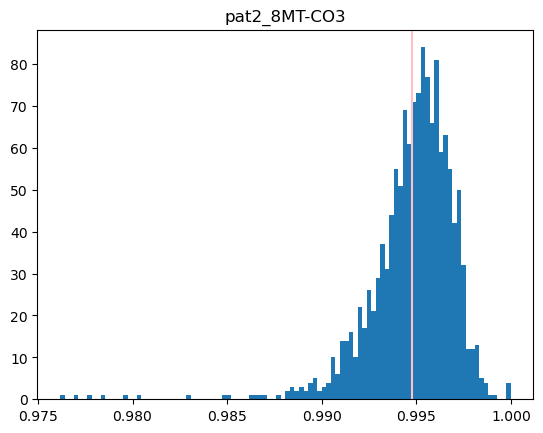

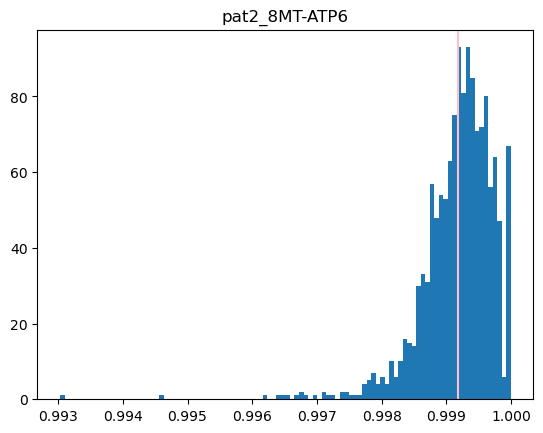

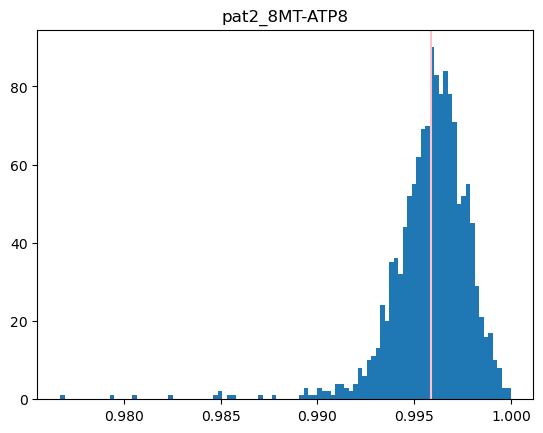

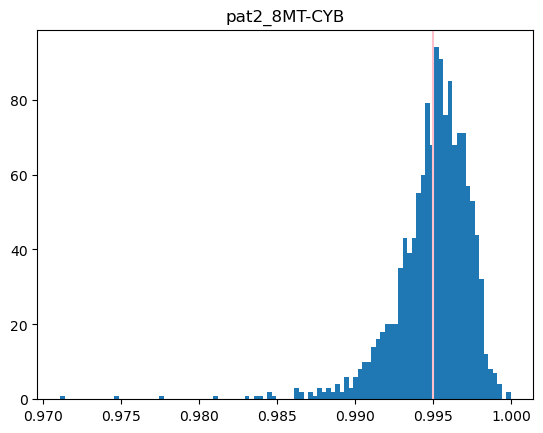

In [18]:
r=1000
uem14_list_n2=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p14n):   
        x=p14_n2[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem14_list_n2.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem14_list_n2=dict(zip(intpro,uem14_list_n2))

uem18_list_n2=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p18n):   
        x=p18_n2[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_8'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
    uem18_list_n2.append(mean(uem_sample_list))
uem18_list_n2=dict(zip(intpro,uem18_list_n2))

uem24_list_n2=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p24n):   
        x=p24_n2[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem24_list_n2.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat2_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem24_list_n2=dict(zip(intpro,uem24_list_n2))

uem28_list_n2=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p28n):   
        x=p28_n2[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem28_list_n2.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat2_8'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem28_list_n2=dict(zip(intpro,uem28_list_n2))

χ² test: H0: Follows nbin, H1: Doesn't Follow

In [19]:
#p1_4
df14=p14n-1
cv=st.chi2.ppf(0.99,df14)
chi2_p14_ts=[]
chi2_p14_res=[]
r=1000
for j in intpro:
    ts=0
    p=uem14_list_n2[j]
    for i in range(p14n):
        o=p14_n2[j][i]
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi2_p14_ts.append(ts)
    chi2_p14_res.append(ts-cv)
chi2_p14_res=dict(zip(intpro,chi2_p14_res))
chi2_p14_res

{'MT-ND1': -259.1006299814303,
 'MT-ND2': -994.5354100216814,
 'MT-ND3': -1110.4332543286637,
 'MT-ND4': -1385.0219285706173,
 'MT-ND4L': 851.3411864570539,
 'MT-ND5': -1156.954331634691,
 'MT-ND6': -1561.9014019043182,
 'MT-CO1': 3559.863627739884,
 'MT-CO2': 4969.570977377631,
 'MT-CO3': 3287.834732136768,
 'MT-ATP6': -1839.3653492497158,
 'MT-ATP8': 3207.6709603345557,
 'MT-CYB': 1849.5343145344264}

In [20]:
#p1_8
df18=p18n-1
cv=st.chi2.ppf(0.99,df18)
chi2_p18_ts=[]
chi2_p18_res=[]
r=1000
for j in intpro:
    ts=0
    p=uem18_list_n2[j]
    for i in range(p18n):
        o=p18_n2[j][i]
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi2_p18_ts.append(ts)
    chi2_p18_res.append(ts-cv)
chi2_p18_res=dict(zip(intpro,chi2_p18_res))
chi2_p18_res

{'MT-ND1': -1086.2564879612235,
 'MT-ND2': -1227.267873724294,
 'MT-ND3': -1285.5864712820774,
 'MT-ND4': -1399.139664297534,
 'MT-ND4L': -462.6046495251087,
 'MT-ND5': -927.546691428279,
 'MT-ND6': -1259.37664232384,
 'MT-CO1': 960.0339049903091,
 'MT-CO2': 823.0536060287031,
 'MT-CO3': -51.17586855621357,
 'MT-ATP6': -1433.6842835822417,
 'MT-ATP8': 470.0422335468329,
 'MT-CYB': -36.365668770027696}

In [21]:
#p2_4
df24=p24n-1
cv=st.chi2.ppf(0.99,df24)
chi2_p24_ts=[]
chi2_p24_res=[]
r=1000
for j in intpro:
    ts=0
    p=uem24_list_n2[j]
    for i in range(p24n):
        o=p24_n2[j][i]
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi2_p24_ts.append(ts)
    chi2_p24_res.append(ts-cv)
chi2_p24_res=dict(zip(intpro,chi2_p24_res))
chi2_p24_res

{'MT-ND1': -1705.0639372465807,
 'MT-ND2': -2278.378735221855,
 'MT-ND3': -1845.2322835038221,
 'MT-ND4': -2501.2593313618245,
 'MT-ND4L': -1602.5596948634711,
 'MT-ND5': -2206.707468257585,
 'MT-ND6': -1875.4958358095714,
 'MT-CO1': 1955.0110015023083,
 'MT-CO2': 626.2349330615343,
 'MT-CO3': -583.5652924087162,
 'MT-ATP6': -2515.9541966190227,
 'MT-ATP8': -338.7471345521785,
 'MT-CYB': -213.1905640435939}

In [22]:
#p2_8
df28=p28n-1
cv=st.chi2.ppf(0.99,df28)
chi2_p28_ts=[]
chi2_p28_res=[]
r=1000
for j in intpro:
    ts=0
    p=uem28_list_n2[j]
    for i in range(p28n):
        o=p28_n2[j][i]
        e=r*(1-p)/p
        ts+=(e-o)**2/e
    chi2_p28_ts.append(ts)
    chi2_p28_res.append(ts-cv)
chi2_p28_res=dict(zip(intpro,chi2_p28_res))
chi2_p28_res

{'MT-ND1': -476.8398241138193,
 'MT-ND2': -760.0681305097527,
 'MT-ND3': -583.9310585132043,
 'MT-ND4': -743.3713364365121,
 'MT-ND4L': -470.84439198819655,
 'MT-ND5': -655.6376203431214,
 'MT-ND6': -252.0406293457654,
 'MT-CO1': 709.0037794292825,
 'MT-CO2': 278.1469399556938,
 'MT-CO3': -89.20066488222665,
 'MT-ATP6': -961.1270513844944,
 'MT-ATP8': -101.73688722536463,
 'MT-CYB': 225.3741148597535}

In [23]:
chi2_p14_resdf=pd.Series(chi2_p14_res)
chi2_p14_resdf=pd.DataFrame(chi2_p14_resdf,columns=['P1_4'])
chi2_p18_resdf=pd.Series(chi2_p18_res)
chi2_p18_resdf=pd.DataFrame(chi2_p18_resdf,columns=['P1_8'])
chi2_p24_resdf=pd.Series(chi2_p24_res)
chi2_p24_resdf=pd.DataFrame(chi2_p24_resdf,columns=['P2_4'])
chi2_p28_resdf=pd.Series(chi2_p28_res)
chi2_p28_resdf=pd.DataFrame(chi2_p28_resdf,columns=['P2_8'])
overall_chi2_res=pd.concat([chi2_p14_resdf,chi2_p18_resdf,chi2_p24_resdf, chi2_p28_resdf], axis=1)

In [24]:
overall_chi2_res

,P1_4,P1_8,P2_4,P2_8
MT-ND1,-259.100630,-1086.256488,-1705.063937,-476.839824
MT-ND2,-994.535410,-1227.267874,-2278.378735,-760.068131
MT-ND3,-1110.433254,-1285.586471,-1845.232284,-583.931059
MT-ND4,-1385.021929,-1399.139664,-2501.259331,-743.371336
MT-ND4L,851.341186,-462.604650,-1602.559695,-470.844392
MT-ND5,-1156.954332,-927.546691,-2206.707468,-655.637620
MT-ND6,-1561.901402,-1259.376642,-1875.495836,-252.040629
MT-CO1,3559.863628,960.033905,1955.011002,709.003779
MT-CO2,4969.570977,823.053606,626.234933,278.146940
MT-CO3,3287.834732,-51.175869,-583.565292,-89.200665


The following portion is plotting the mean and var of the normalised data. (the unnormalised data already settled by Ruiz aka the log-log xform)

In [44]:
#GIves the mean, std, 25,50,75%, min,max
p14_n1_stats=p14_n1.describe().T 
p18_n1_stats=p18_n1.describe().T 
p24_n1_stats=p24_n1.describe().T 
p28_n1_stats=p28_n1.describe().T 

p14_n2_stats=p14_n2.describe().T 
p18_n2_stats=p18_n2.describe().T 
p24_n2_stats=p24_n2.describe().T 
p28_n2_stats=p28_n2.describe().T 

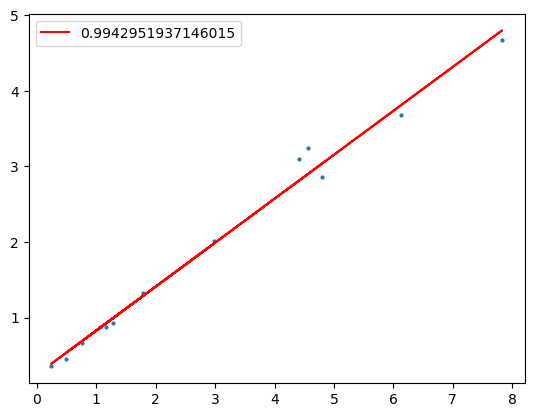

(0.5808371207859149, 0.24795668997626907)

In [45]:
x=p14_n2_stats['mean']
y=p14_n2_stats['std']
fig, ax = plt.subplots(1, 1) 
ax.scatter(x,y,s=4)
lin_p14_n2=st.linregress(x,y)
ax.plot(x,lin_p14_n2.intercept+lin_p14_n2.slope*x,color='red',label=lin_p14_n2.rvalue)
ax.legend()
plt.show()
lin_p14_n2.slope,lin_p14_n2.intercept

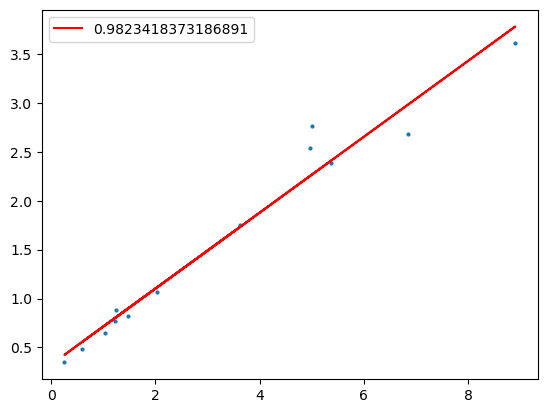

(0.38809657084413907, 0.32539248422265166)

In [27]:
x=p18_n2_stats['mean']
y=p18_n2_stats['std']
fig, ax = plt.subplots(1, 1) 
ax.scatter(x,y,s=4)
lin_p18_n2=st.linregress(x,y)
ax.plot(x,lin_p18_n2.intercept+lin_p18_n2.slope*x,color='red',label=lin_p18_n2.rvalue)
ax.legend()
plt.show()
lin_p18_n2.slope,lin_p18_n2.intercept

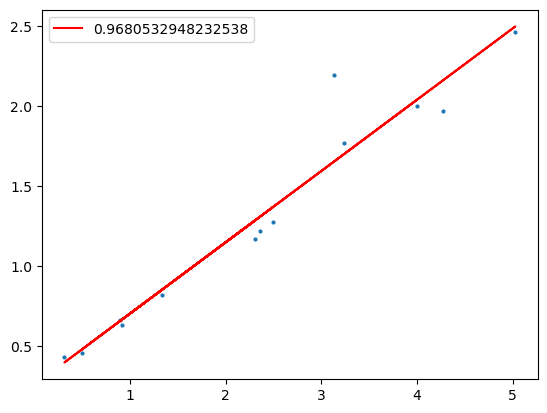

(0.4454279236798031, 0.2583419159131195)

In [28]:
x=p24_n2_stats['mean']
y=p24_n2_stats['std']
fig, ax = plt.subplots(1, 1) 
ax.scatter(x,y,s=4)
lin_p24_n2=st.linregress(x,y)
ax.plot(x,lin_p24_n2.intercept+lin_p24_n2.slope*x,color='red',label=lin_p24_n2.rvalue)
ax.legend()
plt.show()
lin_p24_n2.slope,lin_p24_n2.intercept

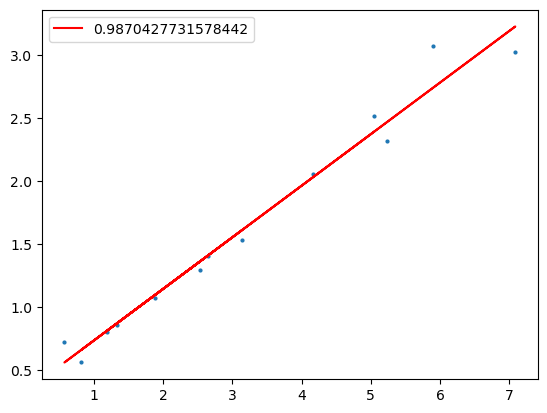

(0.4090722752546736, 0.3279716838999638)

In [29]:
x=p28_n2_stats['mean']
y=p28_n2_stats['std']
fig, ax = plt.subplots(1, 1) 
ax.scatter(x,y,s=4)
lin_p28_n2=st.linregress(x,y)
ax.plot(x,lin_p28_n2.intercept+lin_p28_n2.slope*x,color='red',label=lin_p28_n2.rvalue)
ax.legend()
plt.show()
lin_p28_n2.slope,lin_p28_n2.intercept

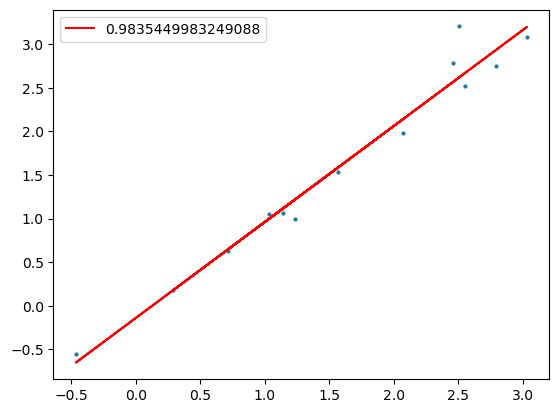

(1.1010707871349665, -0.13968914251414177)

In [30]:
x=np.log(p14_n1_stats['mean'])
y=np.log(p14_n1_stats['std']**2)
fig, ax = plt.subplots(1, 1) 
ax.scatter(x,y,s=4)
lin_p14_n1=st.linregress(x,y)
ax.plot(x,lin_p14_n1.intercept+lin_p14_n1.slope*x,color='red',label=lin_p14_n1.rvalue)
ax.legend()
plt.show()
lin_p14_n1.slope,lin_p14_n1.intercept

In [31]:
p14_n2_stats['std']

MT-ND1     1.319449
MT-ND2     0.871883
MT-ND3     0.931663
MT-ND4     0.667028
MT-ND4L    2.011901
MT-ND5     0.877260
MT-ND6     0.352605
MT-CO1     3.236197
MT-CO2     4.665164
MT-CO3     3.673544
MT-ATP6    0.455798
MT-ATP8    3.095348
MT-CYB     2.858380
Name: std, dtype: float64

Checkpoint 080624

χ² : Gamma distribution for the 1st normalisation (aka the uem normalisation)

Step 1: Xform the normalised data with the transformation of the linear regression line to a y=x line, or at least y=kx line. Scaling mean would scale s.d the same way but translating mean would not affect s.d

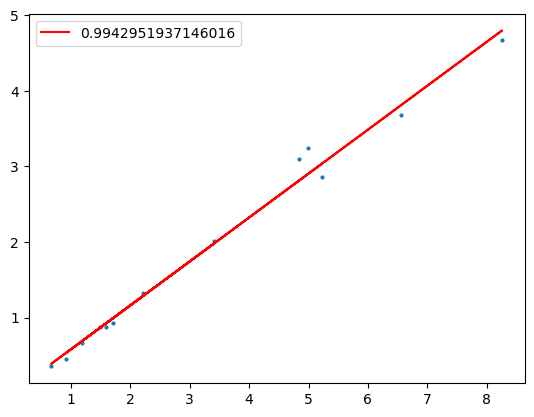

(0.580837120785915, -6.661338147750939e-16)

In [32]:
p14_n2_1=p14_n2.add(lin_p14_n2.intercept/lin_p14_n2.slope) #translate data
p14_n2_1_stats=p14_n2_1.describe().T
x=p14_n2_1_stats['mean']
y=p14_n2_1_stats['std']
fig, ax = plt.subplots(1, 1) 
ax.scatter(x,y,s=4)
lin_p14_n2_1=st.linregress(x,y)
ax.plot(x,lin_p14_n2_1.intercept+lin_p14_n2_1.slope*x,color='red',label=lin_p14_n2_1.rvalue)
ax.legend()
plt.show()
lin_p14_n2_1.slope,lin_p14_n2_1.intercept

In [33]:
may=[]
for i in intpro:
    may.append(lin_p14_n2_1.slope**2-1/(1000*(1-uem14_list_n2[i])))
may

[-0.2222321760295315,
 -0.6078255198713666,
 -0.4442948751749308,
 -0.972838147721964,
 0.001090185293067314,
 -0.523183856348284,
 -3.855974171752079,
 0.11720691243622791,
 0.2084716848673042,
 0.17326750040830363,
 -1.7099464062974778,
 0.10954007759352674,
 0.1279486137192593]

In [34]:
lin_p14_n2_1.slope**2

0.3373717608828716

Performing the chi square test: Parameters of gamma: α,β. By the lin reg, sd=k*mean => α=1/k², β = α/mean=√(α/var)=(√α)/sd

To approximate α, we use the gradient of the lin reg. For β, we use the mean of the data, so β=α/mean.

However, i included 2 other ways through the variance way: the df std which is biased, and np.std, which is unbiased

In [35]:
alp=1/lin_p14_n2_1.slope**2
bet=[]
p14_n2_1_mean=p14_n2_1_stats['mean']
for i in intpro:
    bet.append(alp/p14_n2_1_mean[i])
bet=dict(zip(intpro,bet))
bet

{'MT-ND1': 1.3369753800623834,
 'MT-ND2': 1.9950862341324898,
 'MT-ND3': 1.735989016616938,
 'MT-ND4': 2.490005031663617,
 'MT-ND4L': 0.8691115117846482,
 'MT-ND5': 1.8643347160168138,
 'MT-ND6': 4.455193573083132,
 'MT-CO1': 0.5933660273979358,
 'MT-CO2': 0.35889811395248816,
 'MT-CO3': 0.4514991637671835,
 'MT-ATP6': 3.238391370531389,
 'MT-ATP8': 0.6123597449880477,
 'MT-CYB': 0.5669573887856569}

In [36]:
lol=p14_n2_1['MT-ND1']
wtf=len(lol[(lol<=2) & (lol>1)])
wtf

1186

Part of the χ² test: The following is a function to to calculate the count between 2 values, aka the observed values. 

In [37]:
p14_n2_1_chi_obs=[]
for j in intpro:
    li=[]
    m=floor(min(p14_n2_1[j]))
    M=ceil(max(p14_n2_1[j]))
    d=M-m
    df_data=p14_n2_1[j]
    li.append(len(lol[(df_data>=m) & (df_data<=m+1)])) 
    for i in range(m+1,M,1):
        li.append(len(lol[(df_data>i) & (df_data<=i+1)]))
    p14_n2_1_chi_obs.append(li)
p14_n2_1_chi_obs=dict(zip(intpro,p14_n2_1_chi_obs))
p14_n2_1_chi_obs

{'MT-ND1': [237,
  1186,
  996,
  332,
  69,
  28,
  10,
  7,
  7,
  4,
  2,
  2,
  1,
  1,
  2,
  1,
  1,
  1,
  0,
  0,
  1],
 'MT-ND2': [809, 1559, 393, 82, 18, 11, 7, 3, 3, 1, 2],
 'MT-ND3': [456, 1684, 579, 104, 30, 13, 9, 6, 4, 2, 0, 0, 0, 0, 0, 1],
 'MT-ND4': [1270, 1392, 179, 31, 3, 9, 1, 1, 0, 1, 1],
 'MT-ND4L': [32,
  390,
  951,
  828,
  373,
  158,
  67,
  22,
  20,
  6,
  7,
  7,
  3,
  5,
  6,
  1,
  1,
  3,
  1,
  1,
  0,
  0,
  2,
  1,
  1,
  0,
  0,
  0,
  2],
 'MT-ND5': [632, 1595, 520, 89, 24, 16, 4, 3, 3, 0, 1, 1],
 'MT-ND6': [2577, 281, 24, 4, 1, 0, 1],
 'MT-CO1': [9,
  139,
  420,
  647,
  562,
  443,
  243,
  150,
  100,
  47,
  37,
  16,
  12,
  11,
  12,
  8,
  4,
  4,
  4,
  2,
  1,
  0,
  1,
  3,
  1,
  1,
  0,
  2,
  1,
  0,
  1,
  2,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 'MT-CO2': [2,
  4,
  31,
  112,
  264,
  396,
  459,
  414,
  388,
  267,
  151,
  105,
  71,
  52,
  36,
  31

In [38]:
check=[]
for j in intpro:
    check.append(sum(p14_n2_1_chi_obs[j]))
check

[2888, 2888, 2888, 2888, 2888, 2888, 2888, 2888, 2888, 2888, 2888, 2888, 2888]

Part of the χ² test: Calculating the E values

In [39]:
p14_n2_1_chi_ex=[]
df_p14_n2_1_chi=[]
n=p14n
alp=1/lin_p14_n2_1.slope**2
for j in intpro:
    li=[]
    m=floor(min(p14_n2_1[j]))
    M=ceil(max(p14_n2_1[j]))
    df_p14_n2_1_chi.append(M-m-1)
    beta=bet[j]
    li.append(p14n*(st.gamma.cdf(m+1,a=alp,scale=1/beta)-st.gamma.cdf(m,a=alp,scale=1/beta)))
    for i in range(m+1,M,1):
        li.append(p14n*(st.gamma.cdf(i+1,a=alp,scale=1/beta)-st.gamma.cdf(i,a=alp,scale=1/beta)))
    p14_n2_1_chi_ex.append(li)
p14_n2_1_chi_ex=dict(zip(intpro,p14_n2_1_chi_ex))
df_p14_n2_1_chi=dict(zip(intpro,df_p14_n2_1_chi))
p14_n2_1_chi_ex

{'MT-ND1': [454.43002120575767,
  1015.0533936206464,
  753.7976875415022,
  390.70369105503727,
  170.02297155317086,
  66.72747910636275,
  24.461269924641584,
  8.543426171258895,
  2.8780198777958628,
  0.9427464126539675,
  0.3019915953363723,
  0.09498948093427106,
  0.029428562270397585,
  0.009001140623380088,
  0.002723092178265496,
  0.0008160246872375154,
  0.00024251547934461826,
  7.154803299425083e-05,
  2.097168224324264e-05,
  6.111460853830408e-06,
  1.7716861213656898e-06],
 'MT-ND2': [954.1148177990705,
  1260.533639582371,
  499.22931412534035,
  135.62430275405384,
  30.763159969426244,
  6.277634820416468,
  1.1950217229199005,
  0.21657163651122868,
  0.03783754755595847,
  0.006425977817027473,
  0.0010669689468745247],
 'MT-ND3': [750.7300744705192,
  1217.6052938522187,
  617.6793870801386,
  216.41381784648843,
  63.44586596756393,
  16.749681465699982,
  4.127070468948591,
  0.9683929199494496,
  0.219098294171717,
  0.04819220888879894,
  0.0103645488129657

Test-Stat and conclusion

In [40]:
chi3_p14_n2_conc=[]
for j in intpro:
    chi3_p14_n2_cv=st.chi2.ppf(0.99,df_p14_n2_1_chi[j])
    ele=[(a-b)**2/a for a,b in zip(p14_n2_1_chi_ex[j],p14_n2_1_chi_obs[j])]
    ts=sum(ele)
    chi3_p14_n2_conc.append(ts-chi3_p14_n2_cv)
chi3_p14_n2_conc

[585694.4284016816,
 4316.618213420568,
 262569.56052629894,
 89557.14338077084,
 322464.8767827717,
 2174.7381423110496,
 405276.5934580133,
 134361172.99317253,
 40311.21616646012,
 13293863.144673936,
 195153.73740300865,
 36514729.52753184,
 1548589.106258186]

Checkpoint 090624

In [41]:
bet2=[]
p14_n2_1_var=p14_n2_1_stats['std']**2
for i in intpro:
    bet2.append(np.sqrt(alp/p14_n2_1_var[i]))
bet2

[1.3048268242228878,
 1.9746381188962332,
 1.8479363652565828,
 2.5810791377902156,
 0.8557344455196765,
 1.9625351498596926,
 4.882669572718243,
 0.5319988848293715,
 0.3690444870877859,
 0.46866265197702506,
 3.7772250881129876,
 0.5562065438399192,
 0.6023177516006148]

In [42]:
bet3=[]
for i in intpro:
    bet3.append(np.sqrt(alp/np.var(p14_n2_1[i])))
bet3

[1.3050527878273566,
 1.9749800771841717,
 1.8482563819470512,
 2.58152611660347,
 0.855882637476025,
 1.962875012213935,
 4.883515129841686,
 0.5320910138256166,
 0.3691083964288292,
 0.4687438127105068,
 3.7778792097021174,
 0.5563028650015799,
 0.6024220580784253]

In [43]:
#p14_n2_1
cv=st.chi2.ppf(0.99,df14int)
chi1g_p14int_ts=[]
chi1g_p14int_res=[]
for j in intpro:
    ts=0
    p=uem14int_list[j]
    for i in range(p14n):
        if p14_intsampto[i]==0:
            pass
        else:
            r=100
            o=p14_n1[j][i]
            e=r*(1-p)/p
            ts+=(e-o)**2/e
    chi1_p14int_ts.append(ts)
    chi1_p14int_res.append(ts-cv)
chi1_p14int_res=dict(zip(intpro,chi1_p14int_res))
chi1_p14int_res

AttributeError: 'dict' object has no attribute 'append'

The following started with trying a Partial correlation analysis by plotting each gene against 'non-MT' UMI. but the rvalues were rather low.

Non trasnformed data!

Instead, I experimented a bit and plotted the y against √xy where y=interested gene, x='non-MT' 

Update: This is useless/shouldn't do that

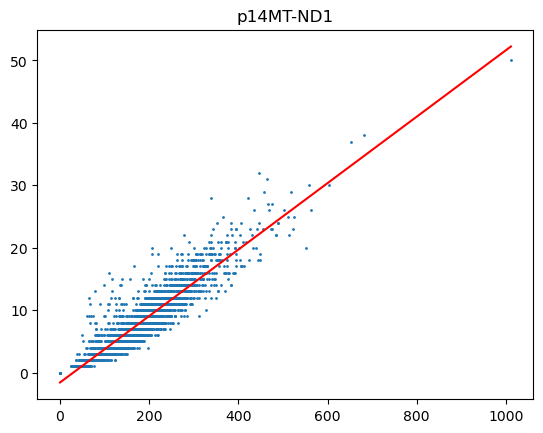

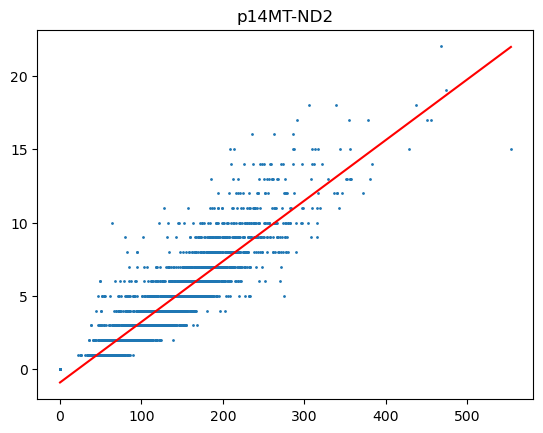

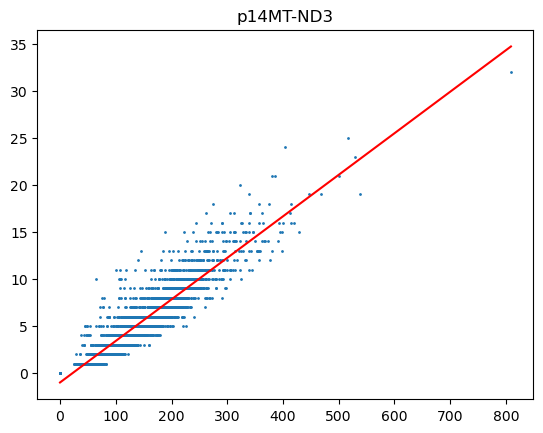

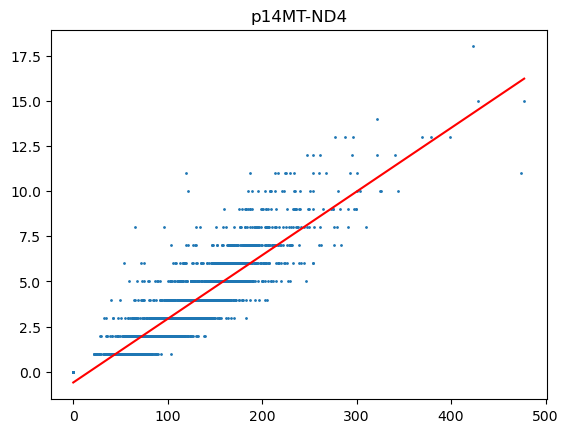

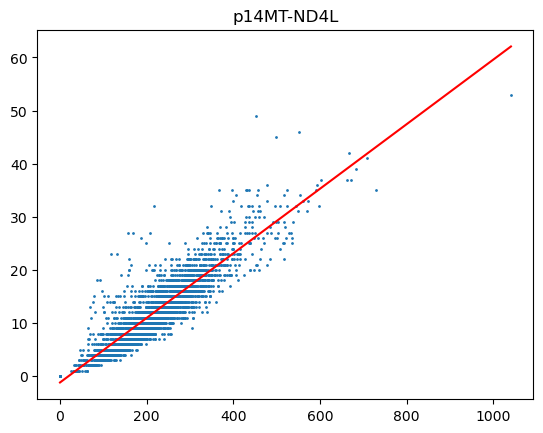

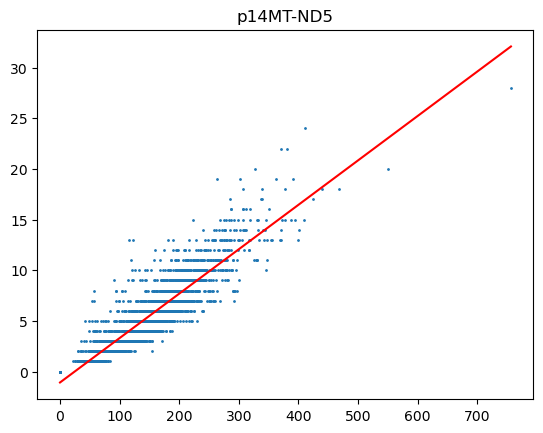

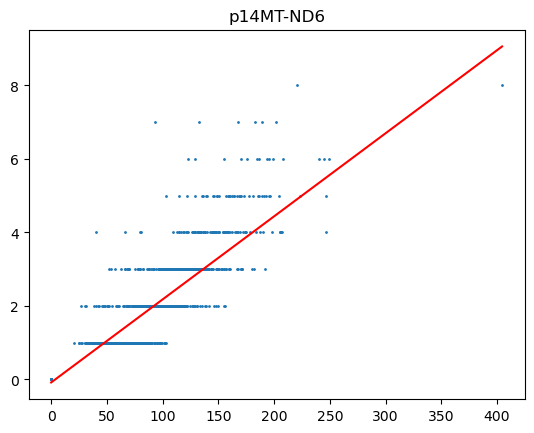

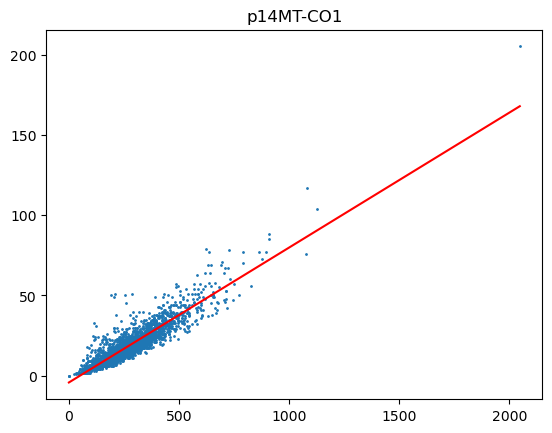

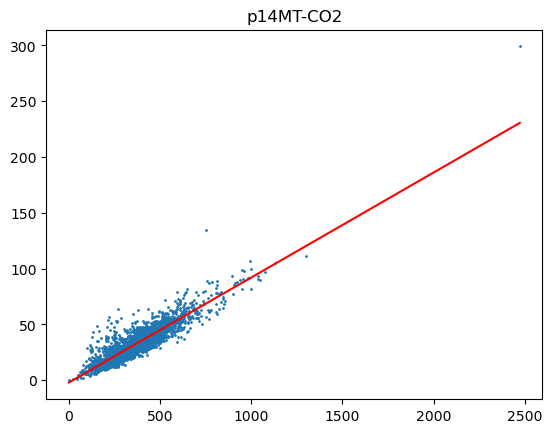

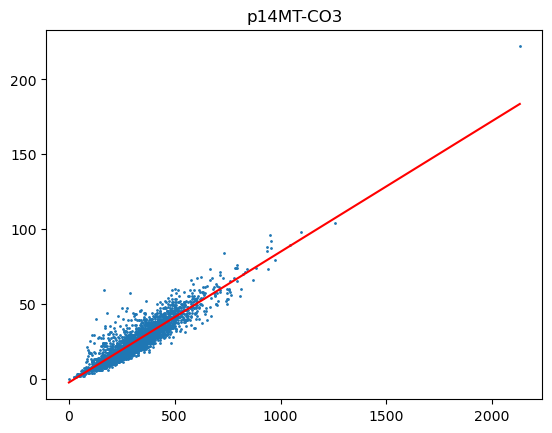

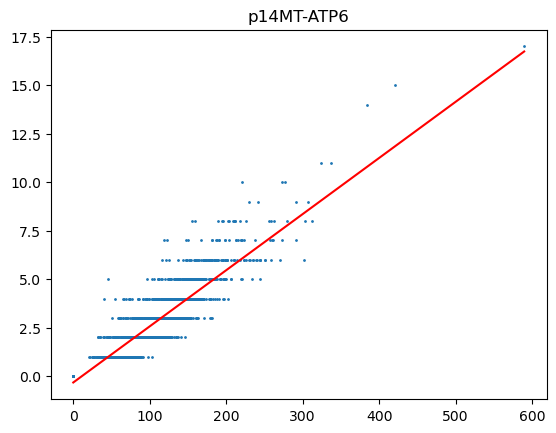

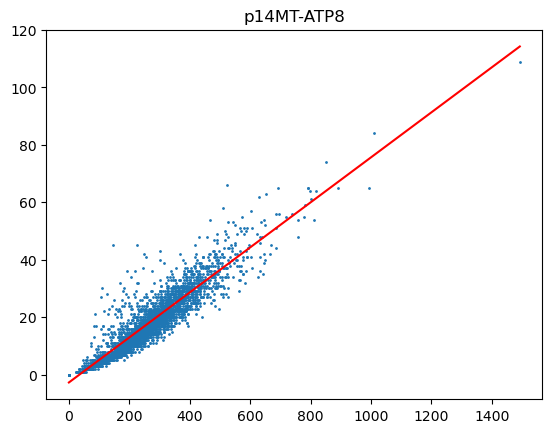

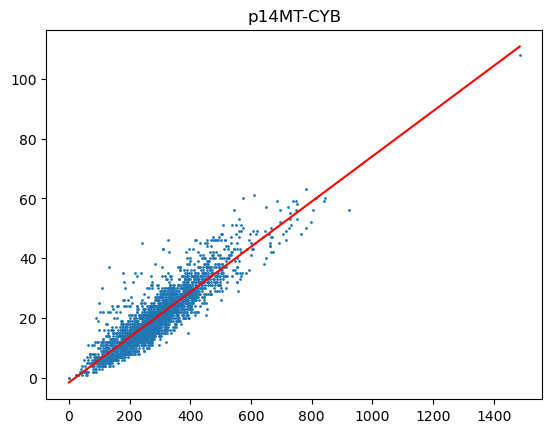

[0.9193543370828551,
 0.8984395985080696,
 0.9118761957878451,
 0.9034948901418001,
 0.886424220964746,
 0.9074537792903041,
 0.9224711938551914,
 0.9039584851169503,
 0.8995383908462922,
 0.9147993472295066,
 0.9201163617981739,
 0.9110017671122358,
 0.8998761126089311]

In [48]:
x=p14['non-MT']
r14_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p14[i]
    ax.set_title('p14'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r14_l.append(lin.rvalue)
    plt.show()
r14_l


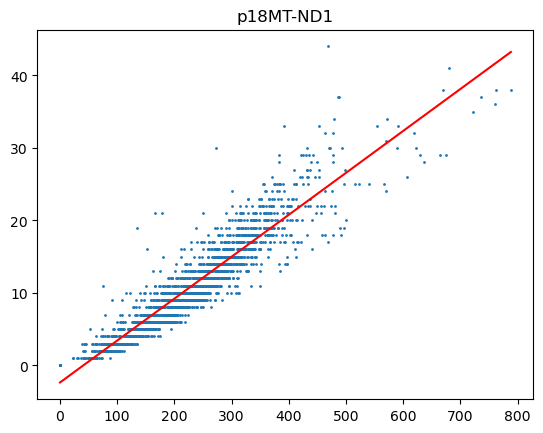

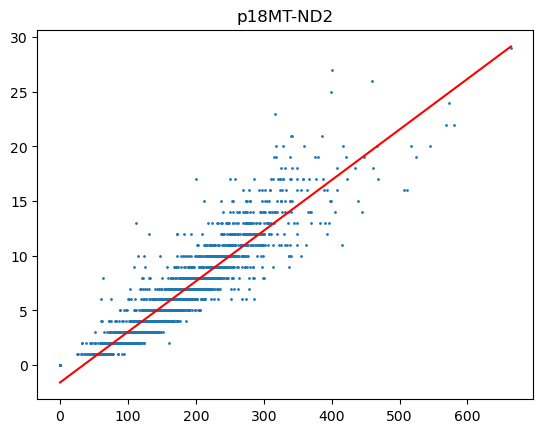

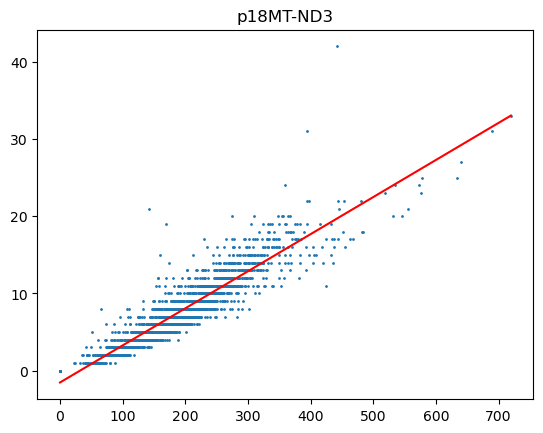

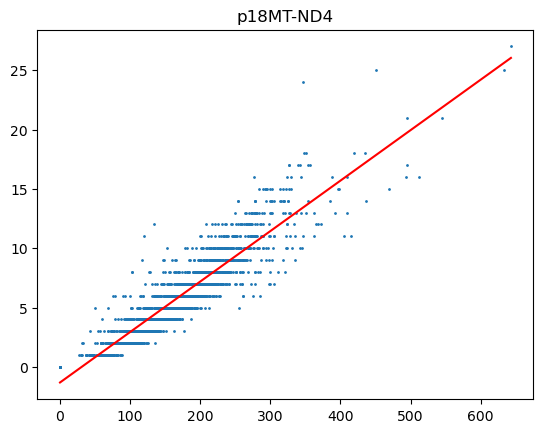

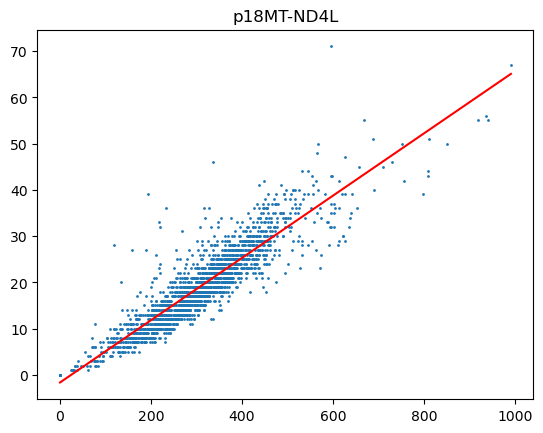

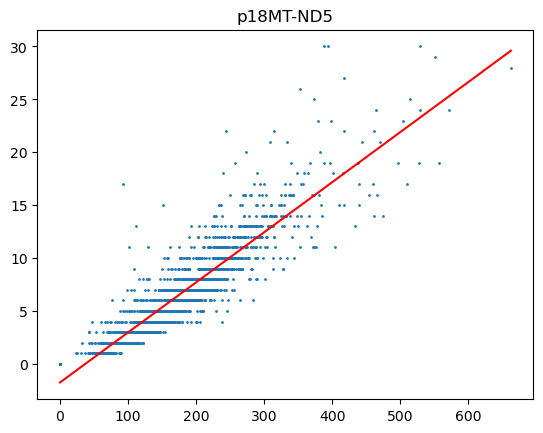

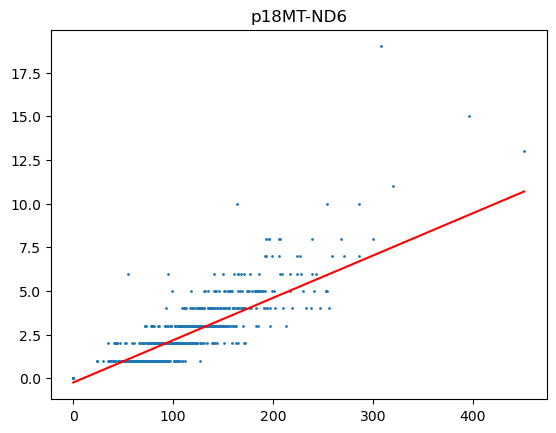

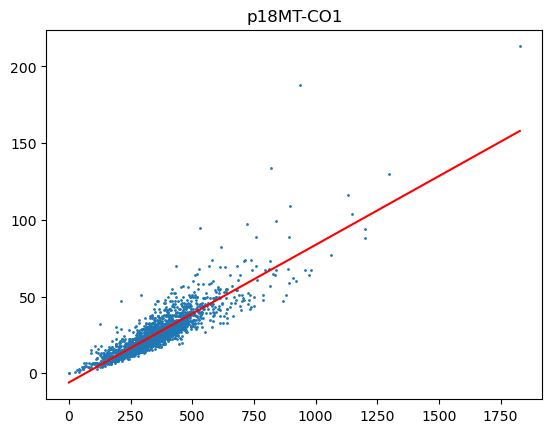

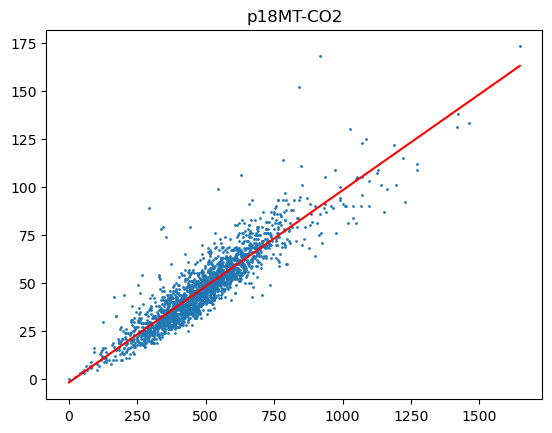

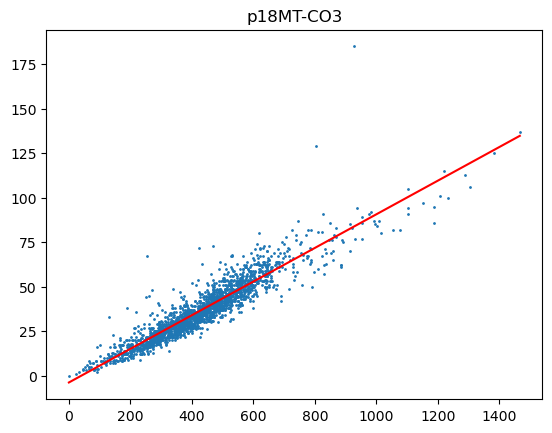

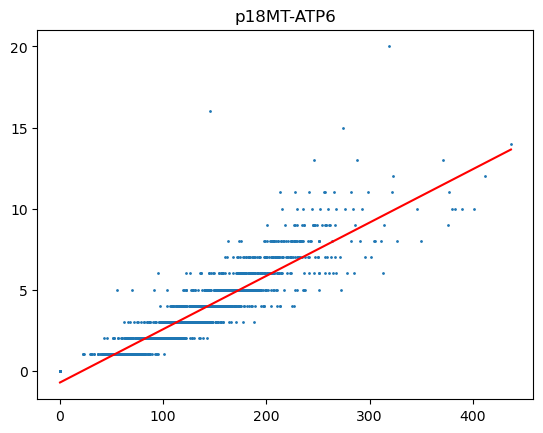

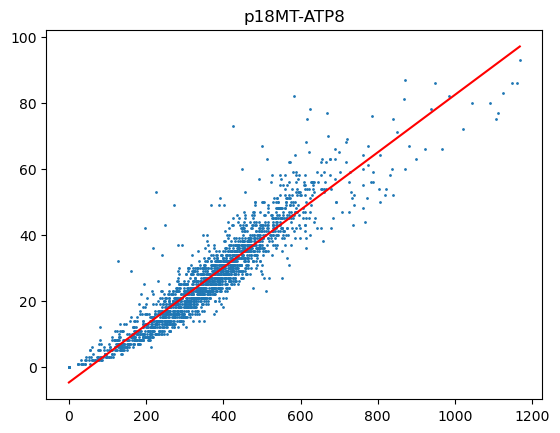

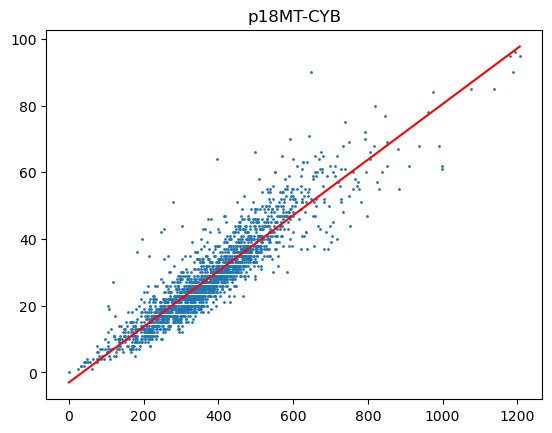

[0.9276197851436622,
 0.9198243489094439,
 0.914136578831026,
 0.9216629872917725,
 0.9019143295338716,
 0.9032289939764799,
 0.9009927368936045,
 0.8777520401260576,
 0.9122054124811845,
 0.9287138790483574,
 0.9157628274881392,
 0.9305091187874125,
 0.9173545211632691]

In [47]:
x=p18['non-MT']
r18_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p18[i]
    ax.set_title('p18'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r18_l.append(lin.rvalue)
    plt.show()
r18_l


In [ ]:
x=p24['non-MT']
r24_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p24[i]
    ax.set_title('p24'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r24_l.append(lin.rvalue)
    plt.show()
r24_l


In [ ]:
x=p28['non-MT']
r28_l=[] #rvalues
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p28[i]
    ax.set_title('p28'+''+i)
    lin_x=np.sqrt(x*y)
    lin_y=y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red')
    r28_l.append(lin.rvalue)
    plt.show()
r28_l


In [ ]:
x=p14['non-MT']
resi14=pd.DataFrame()
i='MT-ND1'
fig, ax = plt.subplots(1, 1) 
y=p14[i]
lin_x=x
lin_y=y
lin=st.linregress(lin_x,lin_y)
fit=lin.intercept+lin.slope*lin_x
resdf=pd.DataFrame(lin_y-fit)
resdf.columns=[i]
resi14=resi14.join(resdf,how='outer')
ax.set_title('p14'+i)
ax.scatter(lin_x,lin_y)
ax.plot(lin_x,fit, color='red',label=lin.rvalue)
plt.legend()
plt.show()
resi14

Calculating the residuals as part of the analysis (and also plotting to check residuals)

In [ ]:
x=p14['non-MT']
resi14=pd.DataFrame()
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    y=p14[i]
    lin_x=x
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resdf=pd.DataFrame(lin_y-fit)
    resdf.columns=[i]
    resi14=resi14.join(resdf,how='outer')
    ax.scatter(lin_x,lin_y)
    ax.plot(lin_x,fit, color='red',label=lin.rvalue)
    ax.set_title('p14'+i)
    plt.legend()
    plt.show()
resi14

Following are the plots of the (untransformed) residuals against another, with the linear regression plotted and corresponding r-value 

In [ ]:
tet=[]
j='MT-ND1'
res_x=resi14[j]
res_col=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'vs'+j)
    lin_x=res_x
    lin_y=res_y
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()

In [ ]:
res_x=resi14['MT-ND1']
res_y=resi14['MT-ND2']
lin_x=np.sqrt(np.abs((res_x*res_y)**2/(0.01)**2-1))
lin_y=np.abs(res_y)


The following plots the covariances and tries to find a relationship + fit

In [ ]:
#plotting |y| against ln(|xy|/k+1)
j='MT-ND1'
res_x=resi14[j]
i='MT-ND2'
fig, ax = plt.subplots(1, 1) 
res_y=resi14[i]
ax.set_title('p14'+i+'against'+i+'*'+j)
lin_x=np.abs(res_x*res_y)
lin_y=np.abs(res_y)
ax.scatter(lin_x,lin_y, s=1)
M=max(lin_x)
m=min(lin_x)
lin=st.linregress(lin_x,lin_y)
l=np.array([m,M])
ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
hyp_x=np.linspace(m,M,1000)
hyp_y=np.log(hyp_x/(res14_D2_sd**1.5)+1)
ax.plot(hyp_x,hyp_y*res14_D2_sd,color='pink')
plt.legend()
plt.show()

In [ ]:
#linreg |y| against ln(|xy|/k+1)
j='MT-ND1'
res_x=resi14[j]
i='MT-ND2'
fig, ax = plt.subplots(1, 1) 
res_y=resi14[i]
ax.set_title('p14'+i+'against'+i+'*'+j)
lin_x1=np.abs(res_x*res_y)
lin_y=np.abs(res_y)
lin_x=np.log(lin_x1/(res14_D2_sd**2)+2)
ax.scatter(lin_x,lin_y, s=1)
M=max(lin_x)
m=min(lin_x)
lin=st.linregress(lin_x,lin_y)
l=np.array([m,M])
ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
plt.legend()
plt.show()

In [ ]:
#linreg |y| against -1/x^n
j='MT-ND1'
res_x=resi14[j]
i='MT-ND2'
fig, ax = plt.subplots(1, 1) 
res_y=resi14[i]
ax.set_title('p14'+i+'against'+i+'*'+j)
lin_x1=np.abs(res_x*res_y)
lin_y=np.abs(res_y)
lin_x=1/(x+1)**2
ax.scatter(lin_x,lin_y, s=1)
M=max(lin_x)
m=min(lin_x)
lin=st.linregress(lin_x,lin_y)
l=np.array([m,M])
ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
plt.legend()
plt.show()

In [ ]:
#test plotting |y| against -1/|xy|
j='MT-ND1'
res_x=resi14[j]
i='MT-ND2'
fig, ax = plt.subplots(1, 1) 
res_y=resi14[i]
ax.set_title('p14'+i+'against'+i+'*'+j)
lin_x=np.abs(res_x*res_y)
lin_y=np.abs(res_y)
ax.scatter(lin_x,lin_y, s=1)
M=max(lin_x)
m=min(lin_x)
#lin=st.linregress(lin_x,lin_y)
l=np.array([m,M])
#ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
hyp_x=np.linspace(m,M,1000)
hyp_y=-500/((hyp_x+10*res14_D2_sd)**1.1)+12
ax.plot(hyp_x,hyp_y,color='pink')
#plt.legend()
plt.show()

In [ ]:
#test plotting |y| against -1/|xy|
j='MT-ND1'
res_x=resi14[j]
i='MT-ND6'
fig, ax = plt.subplots(1, 1) 
res_y=resi14[i]
ax.set_title('p14'+i+'against'+i+'*'+j)
lin_x=np.abs(res_x*res_y)
lin_y=np.abs(res_y)
ax.scatter(lin_x,lin_y, s=1)
M=max(lin_x)
m=min(lin_x)
#lin=st.linregress(lin_x,lin_y)
l=np.array([m,M])
#ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
hyp_x=np.linspace(m,M,1000)
hyp_y=-100/((hyp_x+12)**1.1)+6
ax.plot(hyp_x,hyp_y,color='pink')
#plt.legend()
plt.show()

With hyp_y=-500/((hyp_x+30)**1.1)+12 ≡ -β/((hyp_x+a)^n)+γ, all that's left is to fine a good value/formula for a & n for the linreg

After some testing, we can put a=10*s.d
n=1.1 for now

In [ ]:
#lin reg |y| against -1/(|xy|+k)
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    sd=stdev(resi14[i])
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    lin_x1=np.abs(res_x*res_y)
    lin_y=np.abs(res_y)
    lin_x=-1/((lin_x1+10*sd)**1.2)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()

In [ ]:
#test plotting |y| against |xy|
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    lin_x=np.abs(res_x*res_y)
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    hyp_x=np.linspace(m,M,1000)
    hyp_y=np.log(hyp_x+1)
    ax.plot(hyp_x,hyp_y,color='pink')
    plt.legend()
    plt.show()

In [ ]:
#lin reg |y| against √|xy^2/k-1|
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    lin_x=
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()


In [ ]:
#plotting |y| against √|xy|
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    lin_x=np.sqrt(np.abs(res_x*res_y))
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()


In [ ]:
#plotting |y| against sigmoid(|xy|)
j='MT-ND1'
res_x=resi14[j]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    res_y=resi14[i]
    ax.set_title('p14'+i+'against'+i+'*'+j)
    trans_x=np.abs(res_x*res_y)
    lin_x=
    lin_y=np.abs(res_y)
    ax.scatter(lin_x,lin_y, s=1)
    M=max(lin_x)
    m=min(lin_x)
    lin=st.linregress(lin_x,lin_y)
    l=np.array([m,M])
    ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
    plt.legend()
    plt.show()

Residuals plot: y against x*y

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        res_y=resi14[i]
        ax.set_title('p14'+i+'against'+i+'*'+j)
        lin_x=res_x*res_y
        lin_y=res_y
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
        res_col.append(lin.rvalue)
        plt.legend()
        plt.show()
    r_resi14_l.append(res_col)  

Plotting residuals: y against |xy|

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        res_y=resi14[i]
        ax.set_title('p14'+i+'against'+i+'*'+j)
        lin_x=res_x
        lin_y=np.abs(res_y*res_x)
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red',label=lin.rvalue)
        res_col.append(lin.rvalue)
        plt.legend()
        plt.show()
    r_resi14_l.append(res_col)  

In [ ]:
resi18=pd.DataFrame()
x=p18['non-MT']
for i in intpro:
    y=p18[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi18=resi18.join(pd.DataFrame(lin_y-fit), how='outer')
resi18

In [ ]:
resi14['MT-ND1']

In [ ]:
#function to calc and include r-value onto the plots
def rval(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = st.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [ ]:
res_plot=sns.pairplot(resi14,kind='reg', diag_kind='kde',plot_kws={'line_kws':{'color':'red'}},corner=True)
res_plot.map_lower(rval)
plt.show()

rvalue looks very bleak...
Transforming the residuals to a similar way to above

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        y=resi14[i]
        ax.set_title('p14'+j+'against'+'sqrt'+'('+i+j+')')
        lin_x=x*y
        lin_y=y
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red')
        res_col.append(lin.rvalue)
        plt.show()
    r_resi14_l.append(res_col)  

In [ ]:
tex=resi14['MT-ND1']*resi14['MT-ND2']
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Log?

In [ ]:
tex=np.log(resi14['MT-ND1']*resi14['MT-ND2']+4)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Hyperbola idea but instead, consider reciprocal function and take negative, then translate upwards. 

i.e: -β_1 (xy-k)**(-n) + β_0

In [ ]:
tex=-1/(resi14['MT-ND1']*resi14['MT-ND2']+0.1)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Below are a few code trying to fit a hyperbola (incomplete)

In [ ]:
np.sqrt((resi14['MT-ND1']*resi14['MT-ND2']+1)**2/0.05-1)

In [ ]:
tex=np.sqrt((resi14['MT-ND1']*resi14['MT-ND2'])**2/0.05-1)
np.isnan(tex).any()

In [ ]:
tex=np.sqrt((resi14['MT-ND1']*resi14['MT-ND2']+2)**2-0.25)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

In [ ]:
tex=np.sqrt(resi14['MT-ND1']*resi14['MT-ND2'])
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()

In [ ]:
m_tex=abs(min(resi14['MT-ND1']*resi14['MT-ND2']))
tex=np.sqrt(resi14['MT-ND1']*resi14['MT-ND2']+m_tex)
tey=resi14['MT-ND1']
plt.scatter(tex,tey)
telin=st.linregress(tex,tey)
M=max(tex)
m=min(tex)
tel=np.array([m,M])
plt.plot(tel,telin.intercept+telin.slope*tel,color='red')
plt.show()
telin.rvalue

Code to plot the transformed residuals (incomplete)

In [ ]:
r_resi14_l=[] #r-values for transformed residuals
for j in intpro:
    res_x=resi14[j]
    res_col=[]
    for i in intpro:
        fig, ax = plt.subplots(1, 1) 
        res_y=resi14[i]
        ax.set_title('p14'+j+'against'+'sqrt'+'('+i+j+')')
        lin_x=np.sqrt(res_x*res_y)
        lin_y=res_y
        ax.scatter(lin_x,lin_y, s=1)
        M=max(lin_x)
        m=min(lin_x)
        lin=st.linregress(lin_x,lin_y)
        l=np.array([m,M])
        ax.plot(l,lin.intercept+lin.slope*l,color='red')
        res_col.append(lin.rvalue)
        plt.show()
    r_resi14_l.append(res_col)  

In [ ]:
r_resi14_l

In [ ]:
resi24=pd.DataFrame()
for i in intpro:
    y=p24[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi24=resi24.join(pd.DataFrame(lin_y-fit), how='outer')
resi24

In [ ]:
resi28=pd.DataFrame()
for i in intpro:
    y=p28[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi28=resi28.join(pd.DataFrame(lin_y-fit), how='outer')
resi28

In [ ]:
x=p28['non-MT']
p28_resi=[]
for i in intpro:
    y=p28[i]
    lin_x=np.sqrt(x*y)
    lin_y=y
    lin=st.linregress(lin_x,lin_y)
    fit=lin.intercept+lin.slope*lin_x
    resi=lin_y-fit
p28_resi

For justification: The following was the original plan: plotting gene against non-MT UMI.

Terrible r-value

In [ ]:
r_l=[]
for i in intpro:
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+i)
    ax.scatter(p14['non-MT'],p14[i],s=1)
    beta=st.linregress(p14['non-MT'], p14[i])
    ax.plot(np.linspace(0,20000,num=5),beta.slope*np.linspace(0,20000,num=5)+beta.intercept,color='red')
    r_l.append(beta.rvalue)
    plt.show()


In [ ]:
r_l